# Freemuxlet results

scATAC-seq samples

In [2]:
import pandas as pd
import seaborn as sns

# import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from itertools import combinations
import glob

%load_ext lab_black

In [3]:
!pwd

/lustre1/project/stg_00090/scatac_benchmark/fixedcells_2_cistopic


In [4]:
import os

wdir = "/lustre1/project/stg_00090/scatac_benchmark/fixedcells_2_cistopic"
os.chdir(wdir)

In [5]:
base_dir = "out_fmx/data/freemuxlet"
samples = [
    x.split("/")[-1].split("_freemuxlet.clust1.vcf.gz")[0]
    for x in sorted(glob.glob(base_dir + "/*_freemuxlet.clust1.vcf.gz"))
]
vcf_path_dict = {
    x: os.path.join(base_dir, x + "_freemuxlet.clust1.vcf.gz") for x in samples
}
vcf_path_dict

{'BIO_ddseq_1.FIXEDCELLS': 'out_fmx/data/freemuxlet/BIO_ddseq_1.FIXEDCELLS_freemuxlet.clust1.vcf.gz',
 'BIO_ddseq_2.FIXEDCELLS': 'out_fmx/data/freemuxlet/BIO_ddseq_2.FIXEDCELLS_freemuxlet.clust1.vcf.gz',
 'BIO_ddseq_3.FIXEDCELLS': 'out_fmx/data/freemuxlet/BIO_ddseq_3.FIXEDCELLS_freemuxlet.clust1.vcf.gz',
 'BIO_ddseq_4.FIXEDCELLS': 'out_fmx/data/freemuxlet/BIO_ddseq_4.FIXEDCELLS_freemuxlet.clust1.vcf.gz',
 'BRO_mtscatac_1.FIXEDCELLS': 'out_fmx/data/freemuxlet/BRO_mtscatac_1.FIXEDCELLS_freemuxlet.clust1.vcf.gz',
 'BRO_mtscatac_2.FIXEDCELLS': 'out_fmx/data/freemuxlet/BRO_mtscatac_2.FIXEDCELLS_freemuxlet.clust1.vcf.gz',
 'CNA_10xmultiome_1.FIXEDCELLS': 'out_fmx/data/freemuxlet/CNA_10xmultiome_1.FIXEDCELLS_freemuxlet.clust1.vcf.gz',
 'CNA_10xmultiome_2.FIXEDCELLS': 'out_fmx/data/freemuxlet/CNA_10xmultiome_2.FIXEDCELLS_freemuxlet.clust1.vcf.gz',
 'CNA_10xv11_1.FIXEDCELLS': 'out_fmx/data/freemuxlet/CNA_10xv11_1.FIXEDCELLS_freemuxlet.clust1.vcf.gz',
 'CNA_10xv11_2.FIXEDCELLS': 'out_fmx/data/fr

delete TXG and BIO samples, as they were not ran with our mixture

In [6]:
for sample in list(vcf_path_dict.keys()):
    institute = sample.split("_")[0]
    if institute in ["BIO", "TXG"]:
        print(sample)
        vcf_path_dict.pop(sample)
    if sample in [
        "OHS_s3atac_2.FIXEDCELLS",
        "UCS_ddseq_1.FIXEDCELLS",
        "UCS_ddseq_2.FIXEDCELLS",
    ]:
        print(sample)
        vcf_path_dict.pop(sample)

BIO_ddseq_1.FIXEDCELLS
BIO_ddseq_2.FIXEDCELLS
BIO_ddseq_3.FIXEDCELLS
BIO_ddseq_4.FIXEDCELLS
OHS_s3atac_2.FIXEDCELLS
TXG_10xv11_1.FIXEDCELLS
TXG_10xv2_1.FIXEDCELLS
TXG_10xv2_2.FIXEDCELLS


In [7]:
len(vcf_path_dict)

39

In [8]:
vcf_path_dict

{'BRO_mtscatac_1.FIXEDCELLS': 'out_fmx/data/freemuxlet/BRO_mtscatac_1.FIXEDCELLS_freemuxlet.clust1.vcf.gz',
 'BRO_mtscatac_2.FIXEDCELLS': 'out_fmx/data/freemuxlet/BRO_mtscatac_2.FIXEDCELLS_freemuxlet.clust1.vcf.gz',
 'CNA_10xmultiome_1.FIXEDCELLS': 'out_fmx/data/freemuxlet/CNA_10xmultiome_1.FIXEDCELLS_freemuxlet.clust1.vcf.gz',
 'CNA_10xmultiome_2.FIXEDCELLS': 'out_fmx/data/freemuxlet/CNA_10xmultiome_2.FIXEDCELLS_freemuxlet.clust1.vcf.gz',
 'CNA_10xv11_1.FIXEDCELLS': 'out_fmx/data/freemuxlet/CNA_10xv11_1.FIXEDCELLS_freemuxlet.clust1.vcf.gz',
 'CNA_10xv11_2.FIXEDCELLS': 'out_fmx/data/freemuxlet/CNA_10xv11_2.FIXEDCELLS_freemuxlet.clust1.vcf.gz',
 'CNA_10xv11_3.FIXEDCELLS': 'out_fmx/data/freemuxlet/CNA_10xv11_3.FIXEDCELLS_freemuxlet.clust1.vcf.gz',
 'CNA_10xv11_4.FIXEDCELLS': 'out_fmx/data/freemuxlet/CNA_10xv11_4.FIXEDCELLS_freemuxlet.clust1.vcf.gz',
 'CNA_10xv11_5.FIXEDCELLS': 'out_fmx/data/freemuxlet/CNA_10xv11_5.FIXEDCELLS_freemuxlet.clust1.vcf.gz',
 'CNA_10xv2_1.FIXEDCELLS': 'out_fmx/

remove OHS_s3atac_2 as well

In [9]:
# bcftools filters:
min_DP = 10
min_GQ = 10

fmx_samples = ["CLUST0", "CLUST1"]

intermediate_dir = "out_fmx/data/freemuxlet"
if not os.path.exists(intermediate_dir):
    os.mkdir(intermediate_dir)

tmp_dir = "out_fmx/tmp"
if not os.path.exists(tmp_dir):
    os.mkdir(tmp_dir)

# the file {sample_rename} contains a single line with the new sample name to use in place of the existing CLUST0, CLUST1, etc.

filtered_vcfs = []
parallel_filename = "vcf_concordance.parallel"
with open(parallel_filename, "w") as f:
    for n, (fmxVCFname, fmxVCF) in enumerate(vcf_path_dict.items()):
        for sample in fmx_samples:
            f_vcf = f"{fmxVCFname}.{sample}.vcf.gz"
            filtered_vcfs.append(f_vcf)
            command = f"bcftools view -s {sample} -i 'MIN(FMT/DP)>{min_DP} & MIN(FMT/GQ)>{min_GQ}' {fmxVCF} -O v | bcftools reheader -s out_fmx/sample_rename | bcftools view -O z -o {tmp_dir}/{f_vcf} && tabix -p vcf -f {tmp_dir}/{f_vcf}"

            f.write(f"{command}\n")
            print(command)

parallel_filename = "vcf_concordance2.parallel"
with open(parallel_filename, "w") as f:
    for i, x in enumerate(filtered_vcfs):
        for j, y in enumerate(filtered_vcfs):
            v0 = x.replace(".vcf.gz", "")
            v1 = y.replace(".vcf.gz", "")
            command = f"vcf-compare -g {tmp_dir}/{x} {tmp_dir}/{y} > {tmp_dir}/{v0}_{v1}.vcfcompare"

            f.write(f"{command}\n")
            print(command)

bcftools view -s CLUST0 -i 'MIN(FMT/DP)>10 & MIN(FMT/GQ)>10' out_fmx/data/freemuxlet/BRO_mtscatac_1.FIXEDCELLS_freemuxlet.clust1.vcf.gz -O v | bcftools reheader -s out_fmx/sample_rename | bcftools view -O z -o out_fmx/tmp/BRO_mtscatac_1.FIXEDCELLS.CLUST0.vcf.gz && tabix -p vcf -f out_fmx/tmp/BRO_mtscatac_1.FIXEDCELLS.CLUST0.vcf.gz
bcftools view -s CLUST1 -i 'MIN(FMT/DP)>10 & MIN(FMT/GQ)>10' out_fmx/data/freemuxlet/BRO_mtscatac_1.FIXEDCELLS_freemuxlet.clust1.vcf.gz -O v | bcftools reheader -s out_fmx/sample_rename | bcftools view -O z -o out_fmx/tmp/BRO_mtscatac_1.FIXEDCELLS.CLUST1.vcf.gz && tabix -p vcf -f out_fmx/tmp/BRO_mtscatac_1.FIXEDCELLS.CLUST1.vcf.gz
bcftools view -s CLUST0 -i 'MIN(FMT/DP)>10 & MIN(FMT/GQ)>10' out_fmx/data/freemuxlet/BRO_mtscatac_2.FIXEDCELLS_freemuxlet.clust1.vcf.gz -O v | bcftools reheader -s out_fmx/sample_rename | bcftools view -O z -o out_fmx/tmp/BRO_mtscatac_2.FIXEDCELLS.CLUST0.vcf.gz && tabix -p vcf -f out_fmx/tmp/BRO_mtscatac_2.FIXEDCELLS.CLUST0.vcf.gz
b

# Run in parallel in bash

```
module load BCFtools
module load VCFtools
time cat vcf_concordance.parallel | parallel -j 32 --progress
```

```
module load BCFtools
module load VCFtools
time cat vcf_concordance2.parallel | parallel -j 32 --progress
```

Warnings `Warning: Read 0 lines from out_fmx/tmp/BIO_ddseq_1.FULL.CLUST1.vcf.gz, the tabix index may be broken.` are normal, as some samples only contain 1 genotype.

# Then

In [10]:
samples = sorted(vcf_path_dict.keys())

In [11]:
samples

['BRO_mtscatac_1.FIXEDCELLS',
 'BRO_mtscatac_2.FIXEDCELLS',
 'CNA_10xmultiome_1.FIXEDCELLS',
 'CNA_10xmultiome_2.FIXEDCELLS',
 'CNA_10xv11_1.FIXEDCELLS',
 'CNA_10xv11_2.FIXEDCELLS',
 'CNA_10xv11_3.FIXEDCELLS',
 'CNA_10xv11_4.FIXEDCELLS',
 'CNA_10xv11_5.FIXEDCELLS',
 'CNA_10xv2_1.FIXEDCELLS',
 'CNA_10xv2_2.FIXEDCELLS',
 'CNA_hydrop_1.FIXEDCELLS',
 'CNA_hydrop_2.FIXEDCELLS',
 'CNA_hydrop_3.FIXEDCELLS',
 'CNA_mtscatac_1.FIXEDCELLS',
 'CNA_mtscatac_2.FIXEDCELLS',
 'EPF_hydrop_1.FIXEDCELLS',
 'EPF_hydrop_2.FIXEDCELLS',
 'EPF_hydrop_3.FIXEDCELLS',
 'EPF_hydrop_4.FIXEDCELLS',
 'HAR_ddseq_1.FIXEDCELLS',
 'HAR_ddseq_2.FIXEDCELLS',
 'MDC_mtscatac_1.FIXEDCELLS',
 'MDC_mtscatac_2.FIXEDCELLS',
 'OHS_s3atac_1.FIXEDCELLS',
 'SAN_10xmultiome_1.FIXEDCELLS',
 'SAN_10xmultiome_2.FIXEDCELLS',
 'STA_10xv11_1.FIXEDCELLS',
 'STA_10xv11_2.FIXEDCELLS',
 'VIB_10xmultiome_1.FIXEDCELLS',
 'VIB_10xmultiome_2.FIXEDCELLS',
 'VIB_10xv1_1.FIXEDCELLS',
 'VIB_10xv1_2.FIXEDCELLS',
 'VIB_10xv2_1.FIXEDCELLS',
 'VIB_10xv2_2

In [12]:
if not os.path.exists("out_fmx/genotype_concordance_nrd.txt"):
    fmx_samples = ["CLUST0", "CLUST1"]
    tmp_dir = "out_fmx/tmp"

    nvar = []
    nrd = []
    for r1ix, r1 in enumerate(samples):
        for s1ix, s1 in enumerate(fmx_samples):
            nvar_tmp2 = [f"{r1}.{s1}"]
            nrd_tmp2 = [f"{r1}.{s1}"]
            cnames = []
            for r2ix, r2 in enumerate(samples):
                for s2ix, s2 in enumerate(fmx_samples):
                    f_comp = f"{tmp_dir}/{r1}.{s1}_{r2}.{s2}.vcfcompare"
                    with open(f_comp, "r") as f:
                        dat = f.read().splitlines()
                    # number of variants compared ((fix this!)):
                    # the VN rows contain overlap/unique counts per file
                    # we need to check if there's an entry for both vcfs; this would indicate there are variants overlapping
                    # absence of such an entry would indicate no overlapping variants
                    tmp_nvar = [y for y in dat if y.startswith("VN")]
                    tmp_nvar_split = [x.split("\t") for x in tmp_nvar]
                    v_overlap = 0
                    for i, x in enumerate(tmp_nvar_split):
                        vcf_cnt = sum(["vcf.gz" in y for y in x])
                        if vcf_cnt == 2:
                            # number of variants overlapping:
                            v_overlap = x[1]
                    nvar_tmp2.append(str(v_overlap))

                    ## # old method of getting number of variants overlapping: (doesn't work correctly)
                    ## tmp_sn = [ y.split('\t')[2] for y in dat if y.startswith("SN") ][:3]
                    ## tmp_nvar = sum([ int(y) for y in tmp_sn ])
                    ## nvar_tmp2.append(str(tmp_nvar))

                    # non reference discord rate:
                    # if(v_overlap==0):
                    #    tmp_nrd = "NA"
                    # else:
                    tmp_nrd = [y for y in dat if y.startswith("SN\tNon-reference")]
                    tmp_nrd = tmp_nrd[0].split("\t")[-1]
                    nrd_tmp2.append(tmp_nrd)
                    cnames.append(f"{r2}.{s2}")
            nrd.append(nrd_tmp2)
            nvar.append(nvar_tmp2)

    # write to file:
    f_nvar = open("out_fmx/genotype_concordance_nvar.txt", "w")
    f_nrd = open("out_fmx/genotype_concordance_nrd.txt", "w")
    print("\t".join([""] + cnames), file=f_nvar)
    print("\t".join([""] + cnames), file=f_nrd)
    for i, x in enumerate(nvar):
        print("\t".join(x), file=f_nvar)
        print("\t".join(nrd[i]), file=f_nrd)
    f_nvar.close()
    f_nrd.close()

    print(
        "Created two files:\n\tgenotype_concordance_nvar.txt\n\tgenotype_concordance_nrd.txt\n"
    )

In [13]:
f_nrd = "out_fmx/genotype_concordance_nrd.txt"
f_nvar = "out_fmx/genotype_concordance_nvar.txt"

nrd = pd.read_csv(f_nrd, sep="\t", header=0, index_col=0)
nvar = pd.read_csv(f_nvar, sep="\t", header=0, index_col=0)

In [14]:
nrd.index = [
    x.replace("CNA_10xv11_4", "CNA_10xv11c_1")
    .replace("CNA_10xv11_5", "CNA_10xv11c_2")
    .replace("BRO_mtscatac", "BRO_mtscatacfacs")
    for x in nrd.index
]
nrd.columns = [
    x.replace("CNA_10xv11_4", "CNA_10xv11c_1")
    .replace("CNA_10xv11_5", "CNA_10xv11c_2")
    .replace("BRO_mtscatac", "BRO_mtscatacfacs")
    for x in nrd.columns
]
nvar.index = [
    x.replace("CNA_10xv11_4", "CNA_10xv11c_1")
    .replace("CNA_10xv11_5", "CNA_10xv11c_2")
    .replace("BRO_mtscatac", "BRO_mtscatacfacs")
    for x in nvar.index
]
nvar.columns = [
    x.replace("CNA_10xv11_4", "CNA_10xv11c_1")
    .replace("CNA_10xv11_5", "CNA_10xv11c_2")
    .replace("BRO_mtscatac", "BRO_mtscatacfacs")
    for x in nvar.columns
]

In [15]:
samples_order = [
    "VIB_10xv1_1.FIXEDCELLS",
    "VIB_10xv1_2.FIXEDCELLS",
    "CNA_10xv11_1.FIXEDCELLS",
    "CNA_10xv11_2.FIXEDCELLS",
    "CNA_10xv11_3.FIXEDCELLS",
    "STA_10xv11_1.FIXEDCELLS",
    "STA_10xv11_2.FIXEDCELLS",
    "CNA_10xv11c_1.FIXEDCELLS",
    "CNA_10xv11c_2.FIXEDCELLS",
    "CNA_10xv2_1.FIXEDCELLS",
    "CNA_10xv2_2.FIXEDCELLS",
    "VIB_10xv2_1.FIXEDCELLS",
    "VIB_10xv2_2.FIXEDCELLS",
    "CNA_10xmultiome_1.FIXEDCELLS",
    "CNA_10xmultiome_2.FIXEDCELLS",
    "SAN_10xmultiome_1.FIXEDCELLS",
    "SAN_10xmultiome_2.FIXEDCELLS",
    "VIB_10xmultiome_1.FIXEDCELLS",
    "VIB_10xmultiome_2.FIXEDCELLS",
    "CNA_mtscatac_1.FIXEDCELLS",
    "CNA_mtscatac_2.FIXEDCELLS",
    "MDC_mtscatac_1.FIXEDCELLS",
    "MDC_mtscatac_2.FIXEDCELLS",
    "BRO_mtscatacfacs_1.FIXEDCELLS",
    "BRO_mtscatacfacs_2.FIXEDCELLS",
    "HAR_ddseq_1.FIXEDCELLS",
    "HAR_ddseq_2.FIXEDCELLS",
    "OHS_s3atac_1.FIXEDCELLS",
    "CNA_hydrop_1.FIXEDCELLS",
    "CNA_hydrop_2.FIXEDCELLS",
    "CNA_hydrop_3.FIXEDCELLS",
    "EPF_hydrop_1.FIXEDCELLS",
    "EPF_hydrop_2.FIXEDCELLS",
    "EPF_hydrop_3.FIXEDCELLS",
    "EPF_hydrop_4.FIXEDCELLS",
    "VIB_hydrop_11.FIXEDCELLS",
    "VIB_hydrop_12.FIXEDCELLS",
    "VIB_hydrop_21.FIXEDCELLS",
    "VIB_hydrop_22.FIXEDCELLS",
]

/opt/venv/lib/python3.8/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


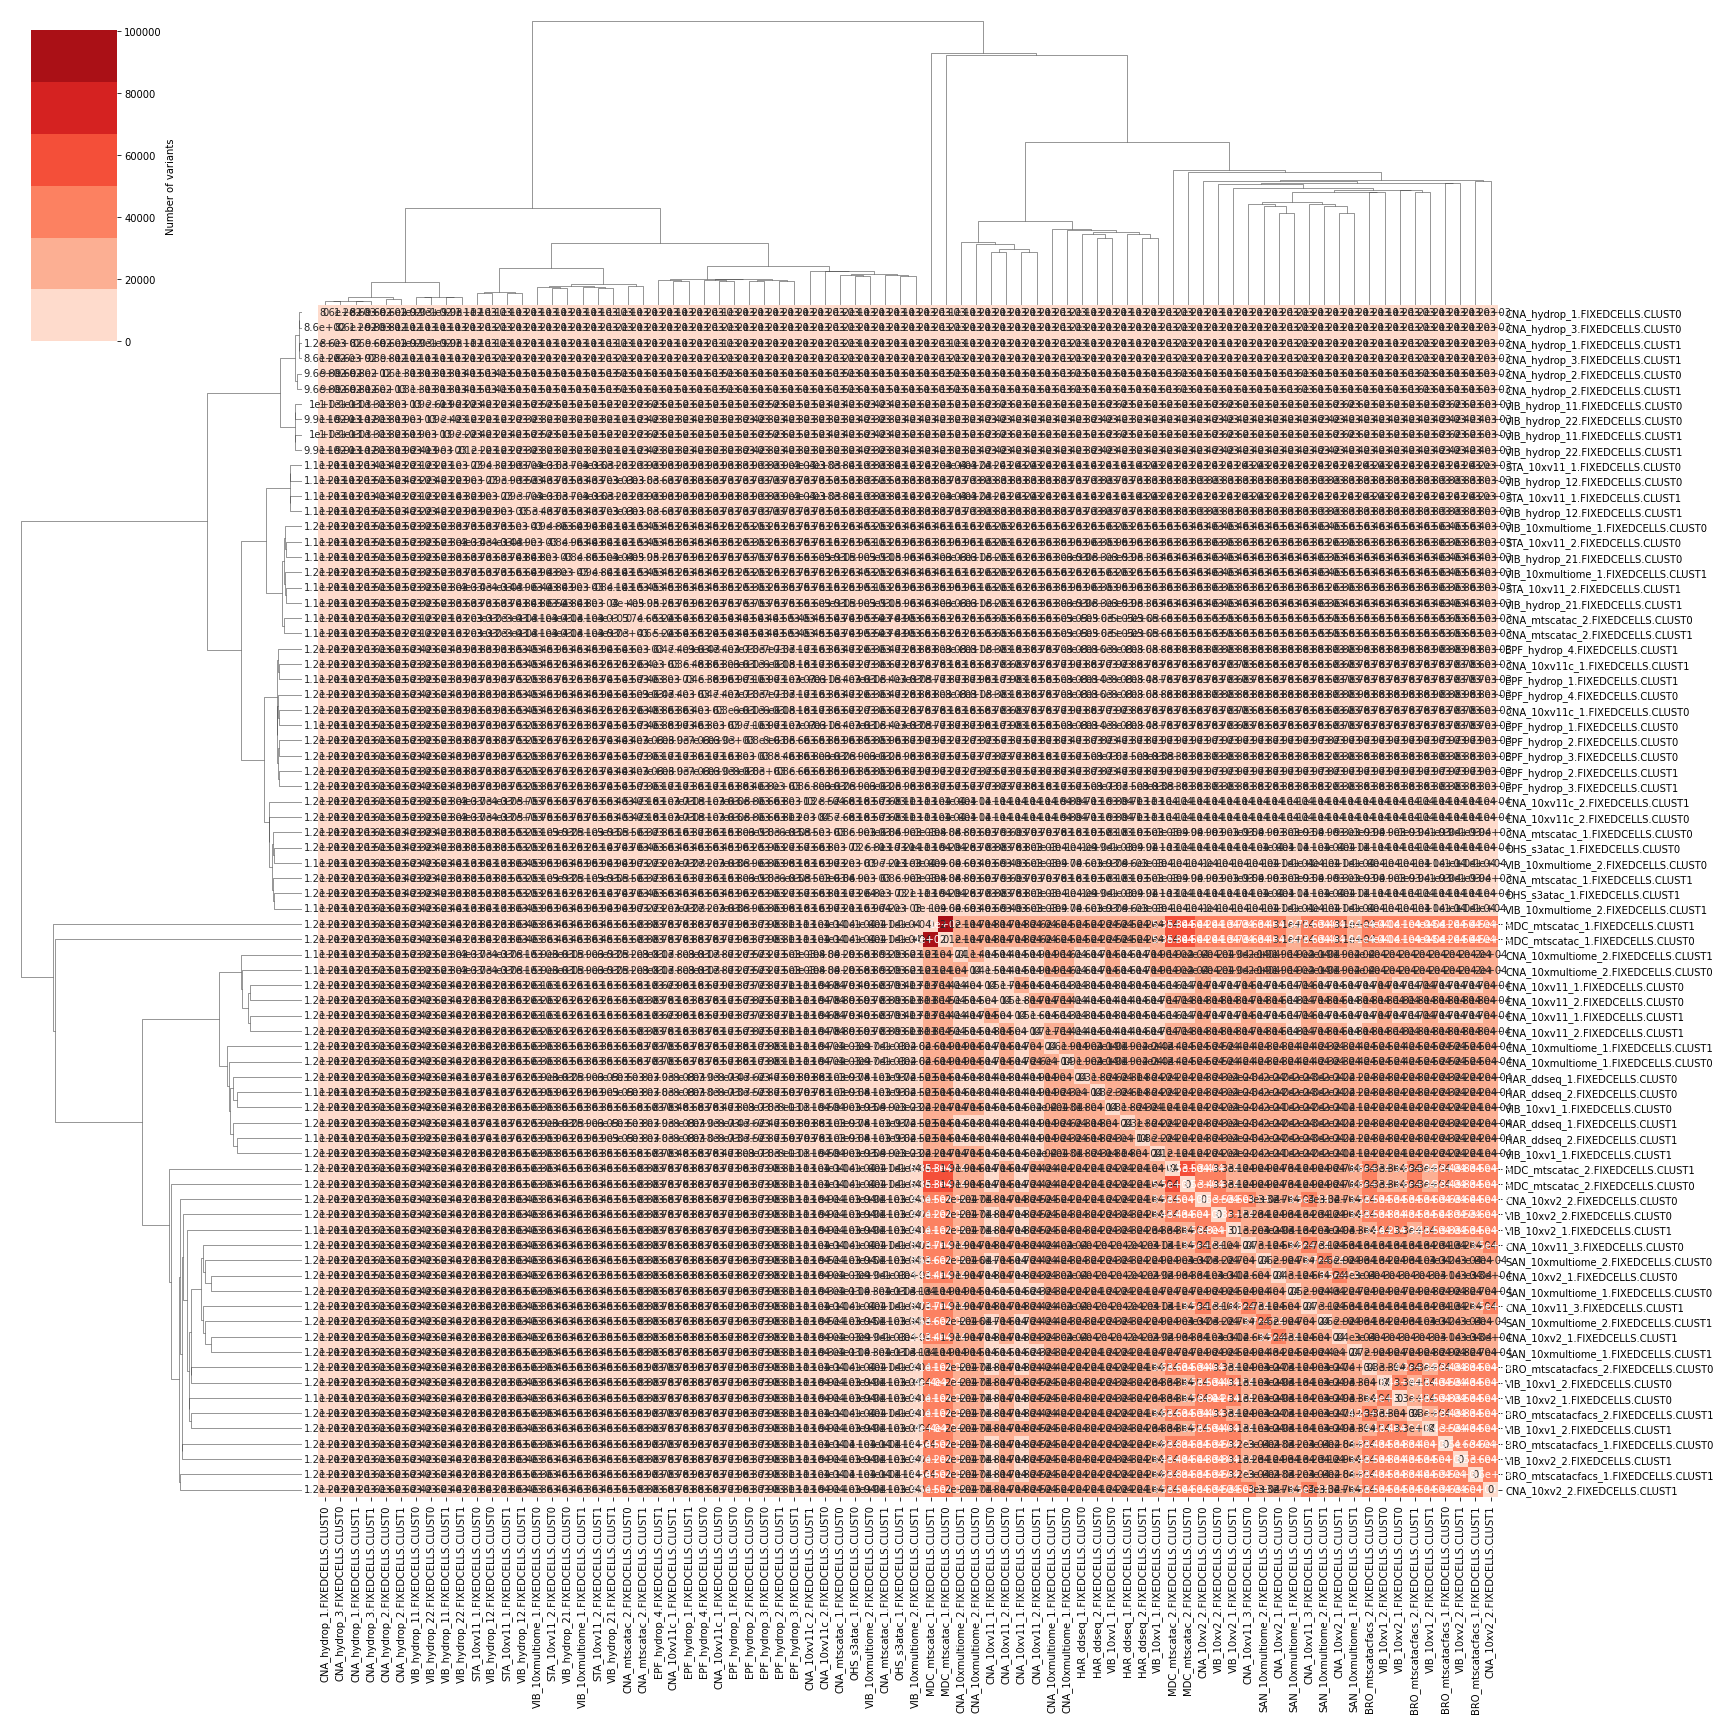

In [16]:
g = sns.clustermap(
    nvar.round(1),
    annot=True,
    linecolor="gray",
    yticklabels=True,
    xticklabels=True,
    vmin=0.0,
    vmax=nvar.max().max(),  # row_colors=colormap,
    cmap=sns.color_palette("Reds"),
    # cmap='vlag',
    cbar_kws={"label": "Number of variants"},
    figsize=(24, 24),
)
g.cax.set_visible(True)
g.savefig(
    "out_fmx/freemuxlet_nvar_fulldata.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
)

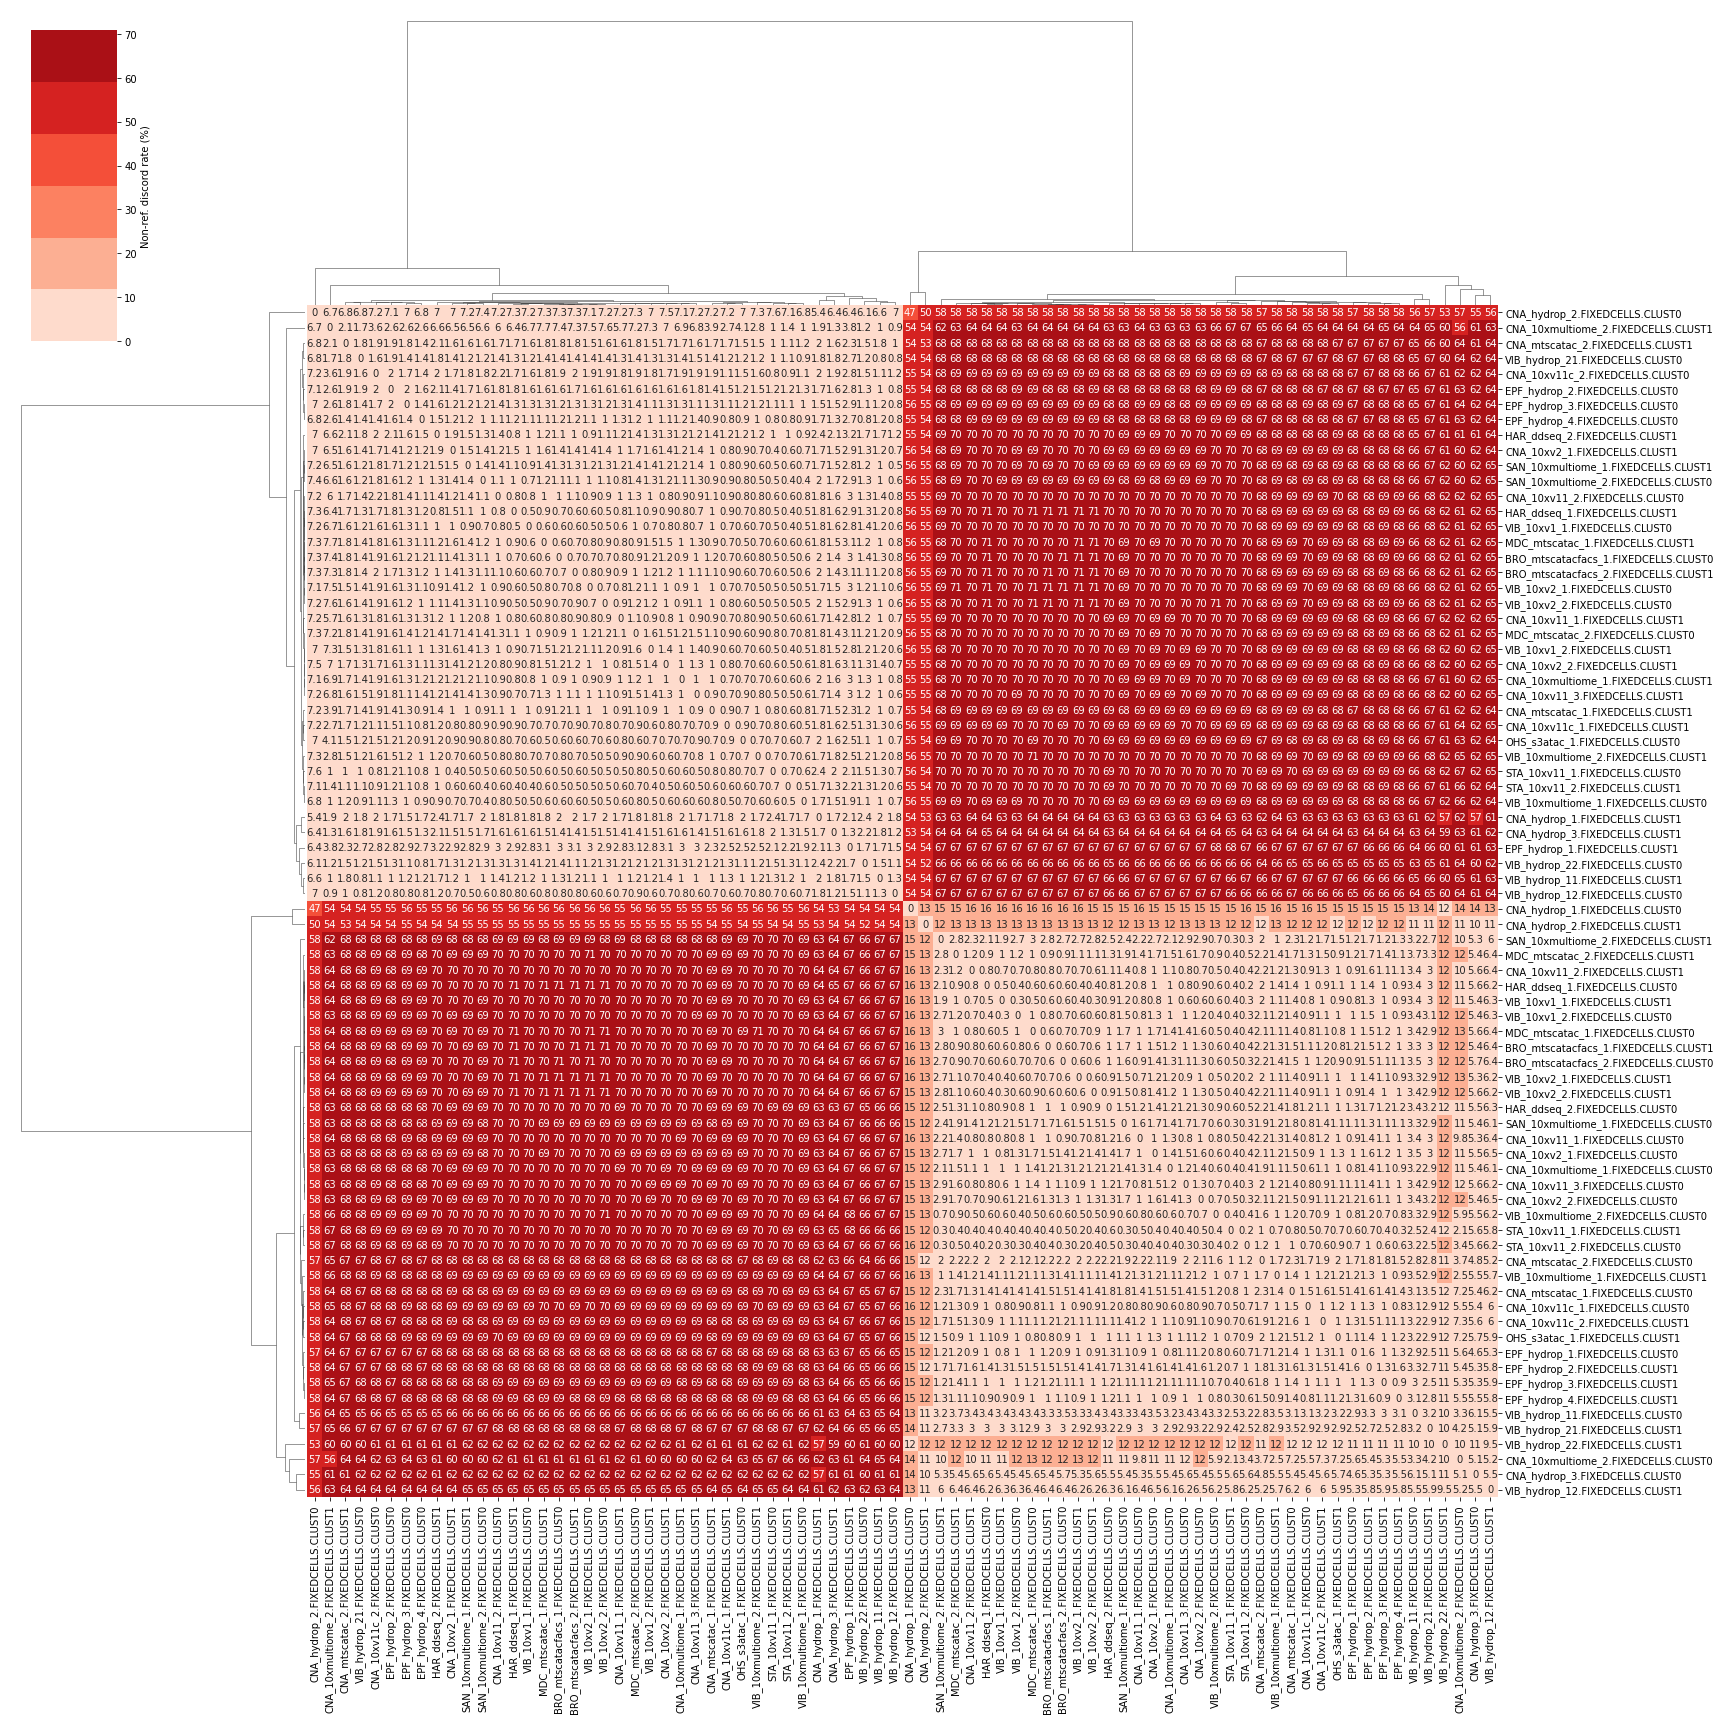

In [17]:
g = sns.clustermap(
    nrd.round(1),
    annot=True,
    linecolor="gray",
    yticklabels=True,
    xticklabels=True,
    vmin=0.0,
    vmax=nrd.max().max(),  # row_colors=colormap,
    cmap=sns.color_palette("Reds"),
    # cmap='vlag',
    cbar_kws={"label": "Non-ref. discord rate (%)"},
    figsize=(24, 24),
)
g.cax.set_visible(True)
g.savefig(
    "out_fmx/freemuxlet_nrd_fulldata.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
)

In [18]:
order = [nrd.index[x] for x in g.dendrogram_col.reordered_ind]
top_n = len(samples)
for line in ["'" + x[0:-7] + "', " for x in order][0:top_n]:
    print(line)

print("\n")

for line in ["c('" + x[0:-7] + "', " + x[-1] + ")," for x in order][0:top_n]:
    print(line)

'CNA_hydrop_2.FIXEDCELLS', 
'CNA_10xmultiome_2.FIXEDCELLS', 
'CNA_mtscatac_2.FIXEDCELLS', 
'VIB_hydrop_21.FIXEDCELLS', 
'CNA_10xv11c_2.FIXEDCELLS', 
'EPF_hydrop_2.FIXEDCELLS', 
'EPF_hydrop_3.FIXEDCELLS', 
'EPF_hydrop_4.FIXEDCELLS', 
'HAR_ddseq_2.FIXEDCELLS', 
'CNA_10xv2_1.FIXEDCELLS', 
'SAN_10xmultiome_1.FIXEDCELLS', 
'SAN_10xmultiome_2.FIXEDCELLS', 
'CNA_10xv11_2.FIXEDCELLS', 
'HAR_ddseq_1.FIXEDCELLS', 
'VIB_10xv1_1.FIXEDCELLS', 
'MDC_mtscatac_1.FIXEDCELLS', 
'BRO_mtscatacfacs_1.FIXEDCELLS', 
'BRO_mtscatacfacs_2.FIXEDCELLS', 
'VIB_10xv2_1.FIXEDCELLS', 
'VIB_10xv2_2.FIXEDCELLS', 
'CNA_10xv11_1.FIXEDCELLS', 
'MDC_mtscatac_2.FIXEDCELLS', 
'VIB_10xv1_2.FIXEDCELLS', 
'CNA_10xv2_2.FIXEDCELLS', 
'CNA_10xmultiome_1.FIXEDCELLS', 
'CNA_10xv11_3.FIXEDCELLS', 
'CNA_mtscatac_1.FIXEDCELLS', 
'CNA_10xv11c_1.FIXEDCELLS', 
'OHS_s3atac_1.FIXEDCELLS', 
'VIB_10xmultiome_2.FIXEDCELLS', 
'STA_10xv11_1.FIXEDCELLS', 
'STA_10xv11_2.FIXEDCELLS', 
'VIB_10xmultiome_1.FIXEDCELLS', 
'CNA_hydrop_1.FIXEDCELLS', 
'CN

In [19]:
clust_dict = {}
for index in [nrd.index[x] for x in g.dendrogram_col.reordered_ind]:
    sample = index.split(".C")[0]
    # print(samples_order.index(sample))
    clust_dict[sample] = index.split("LLS.")[1]


clust_dict_inverse = {
    k: v.replace("0", "z").replace("1", "0").replace("z", "1")
    for k, v in clust_dict.items()
}
clust_dict

{'CNA_hydrop_2.FIXEDCELLS': 'CLUST1',
 'CNA_10xmultiome_2.FIXEDCELLS': 'CLUST0',
 'CNA_mtscatac_2.FIXEDCELLS': 'CLUST0',
 'VIB_hydrop_21.FIXEDCELLS': 'CLUST1',
 'CNA_10xv11c_2.FIXEDCELLS': 'CLUST1',
 'EPF_hydrop_2.FIXEDCELLS': 'CLUST1',
 'EPF_hydrop_3.FIXEDCELLS': 'CLUST1',
 'EPF_hydrop_4.FIXEDCELLS': 'CLUST1',
 'HAR_ddseq_2.FIXEDCELLS': 'CLUST0',
 'CNA_10xv2_1.FIXEDCELLS': 'CLUST0',
 'SAN_10xmultiome_1.FIXEDCELLS': 'CLUST0',
 'SAN_10xmultiome_2.FIXEDCELLS': 'CLUST1',
 'CNA_10xv11_2.FIXEDCELLS': 'CLUST1',
 'HAR_ddseq_1.FIXEDCELLS': 'CLUST0',
 'VIB_10xv1_1.FIXEDCELLS': 'CLUST1',
 'MDC_mtscatac_1.FIXEDCELLS': 'CLUST0',
 'BRO_mtscatacfacs_1.FIXEDCELLS': 'CLUST1',
 'BRO_mtscatacfacs_2.FIXEDCELLS': 'CLUST0',
 'VIB_10xv2_1.FIXEDCELLS': 'CLUST1',
 'VIB_10xv2_2.FIXEDCELLS': 'CLUST1',
 'CNA_10xv11_1.FIXEDCELLS': 'CLUST0',
 'MDC_mtscatac_2.FIXEDCELLS': 'CLUST1',
 'VIB_10xv1_2.FIXEDCELLS': 'CLUST0',
 'CNA_10xv2_2.FIXEDCELLS': 'CLUST0',
 'CNA_10xmultiome_1.FIXEDCELLS': 'CLUST0',
 'CNA_10xv11_3.FIX

In [20]:
samples_order_cat = [x + "." + clust_dict[x] for x in samples_order]
samples_order_cat = samples_order_cat + [
    x + "." + clust_dict_inverse[x] for x in samples_order
]
samples_order_cat

['VIB_10xv1_1.FIXEDCELLS.CLUST1',
 'VIB_10xv1_2.FIXEDCELLS.CLUST0',
 'CNA_10xv11_1.FIXEDCELLS.CLUST0',
 'CNA_10xv11_2.FIXEDCELLS.CLUST1',
 'CNA_10xv11_3.FIXEDCELLS.CLUST0',
 'STA_10xv11_1.FIXEDCELLS.CLUST1',
 'STA_10xv11_2.FIXEDCELLS.CLUST0',
 'CNA_10xv11c_1.FIXEDCELLS.CLUST0',
 'CNA_10xv11c_2.FIXEDCELLS.CLUST1',
 'CNA_10xv2_1.FIXEDCELLS.CLUST0',
 'CNA_10xv2_2.FIXEDCELLS.CLUST0',
 'VIB_10xv2_1.FIXEDCELLS.CLUST1',
 'VIB_10xv2_2.FIXEDCELLS.CLUST1',
 'CNA_10xmultiome_1.FIXEDCELLS.CLUST0',
 'CNA_10xmultiome_2.FIXEDCELLS.CLUST0',
 'SAN_10xmultiome_1.FIXEDCELLS.CLUST0',
 'SAN_10xmultiome_2.FIXEDCELLS.CLUST1',
 'VIB_10xmultiome_1.FIXEDCELLS.CLUST1',
 'VIB_10xmultiome_2.FIXEDCELLS.CLUST0',
 'CNA_mtscatac_1.FIXEDCELLS.CLUST0',
 'CNA_mtscatac_2.FIXEDCELLS.CLUST0',
 'MDC_mtscatac_1.FIXEDCELLS.CLUST0',
 'MDC_mtscatac_2.FIXEDCELLS.CLUST1',
 'BRO_mtscatacfacs_1.FIXEDCELLS.CLUST1',
 'BRO_mtscatacfacs_2.FIXEDCELLS.CLUST0',
 'HAR_ddseq_1.FIXEDCELLS.CLUST0',
 'HAR_ddseq_2.FIXEDCELLS.CLUST0',
 'OHS_s3ata

In [21]:
test = int(len(samples_order_cat) / 2)
samples_order_cat_half = samples_order_cat[:test]

In [22]:
nrd = nrd.loc[samples_order_cat_half][samples_order_cat]

In [23]:
nrd_temp = nrd.loc[samples_order_cat_half][samples_order_cat_half]

In [24]:
nrd_median = pd.DataFrame(nrd_temp.median(axis=1))
nrd_median.index = [x.split(".C")[0] for x in nrd_median.index]
nrd_median

0
VIB_10xv1_1.FIXEDCELLS          0.87
VIB_10xv1_2.FIXEDCELLS          1.04
CNA_10xv11_1.FIXEDCELLS         1.05
CNA_10xv11_2.FIXEDCELLS         1.06
CNA_10xv11_3.FIXEDCELLS         1.17
STA_10xv11_1.FIXEDCELLS         0.48
STA_10xv11_2.FIXEDCELLS         0.50
CNA_10xv11c_1.FIXEDCELLS        1.00
CNA_10xv11c_2.FIXEDCELLS        1.17
CNA_10xv2_1.FIXEDCELLS          1.39
CNA_10xv2_2.FIXEDCELLS          1.33
VIB_10xv2_1.FIXEDCELLS          1.05
VIB_10xv2_2.FIXEDCELLS          1.02
CNA_10xmultiome_1.FIXEDCELLS    1.25
CNA_10xmultiome_2.FIXEDCELLS   10.31
SAN_10xmultiome_1.FIXEDCELLS    1.54
SAN_10xmultiome_2.FIXEDCELLS    2.39
VIB_10xmultiome_1.FIXEDCELLS    1.23
VIB_10xmultiome_2.FIXEDCELLS    0.72
CNA_mtscatac_1.FIXEDCELLS       1.48
CNA_mtscatac_2.FIXEDCELLS       2.07
MDC_mtscatac_1.FIXEDCELLS       1.13
MDC_mtscatac_2.FIXEDCELLS       1.37
BRO_mtscatacfacs_1.FIXEDCELLS   1.15
BRO_mtscatacfacs_2.FIXEDCELLS   1.09
HAR_ddseq_1.FIXEDCELLS          0.96
HAR_ddseq_2.FIXEDCELLS          1.21
OHS_s3atac_1.FIXEDCELLS         1.11
CNA_hydrop_1.FIXEDCELLS        15.31
CNA_hydrop_2.FIXEDCELLS        12.47
CNA_hydrop_3.FIXEDCELLS         5.46
EPF_hydrop_1.FIXEDCELLS         1.14
EPF_hydrop_2.FIXEDCELLS         1.52
EPF_hydrop_3.FIXEDCELLS         1.09
EPF_hydrop_4.FIXEDCELLS         1.06
VIB_hydrop_11.FIXEDCELLS        3.32
VIB_hydrop_12.FIXEDCELLS        6.20
VIB_hydrop_21.FIXEDCELLS        2.94
VIB_hydrop_22.FIXEDCELLS       11.95

In [25]:
sample_id_ultrashort_alias_dict = {
    "BIO_ddseq_1.FIXEDCELLS": "ddS Bi1",
    "BIO_ddseq_2.FIXEDCELLS": "ddS Bi2",
    "BIO_ddseq_3.FIXEDCELLS": "ddS Bi3",
    "BIO_ddseq_4.FIXEDCELLS": "ddS Bi4",
    "BRO_mtscatacfacs_1.FIXEDCELLS": "mt* Br1",
    "BRO_mtscatacfacs_2.FIXEDCELLS": "mt* Br2",
    "CNA_10xmultiome_1.FIXEDCELLS": "MO C1",
    "CNA_10xmultiome_2.FIXEDCELLS": "MO C2",
    "CNA_10xv11_1.FIXEDCELLS": "v1.1 C1",
    "CNA_10xv11_2.FIXEDCELLS": "v1.1 C2",
    "CNA_10xv11_3.FIXEDCELLS": "v1.1 C3",
    "CNA_10xv11c_1.FIXEDCELLS": "v1.1c C1",
    "CNA_10xv11c_2.FIXEDCELLS": "v1.1c C2",
    "CNA_10xv2_1.FIXEDCELLS": "v2 C1",
    "CNA_10xv2_2.FIXEDCELLS": "v2 C2",
    "CNA_hydrop_1.FIXEDCELLS": "Hy C1",
    "CNA_hydrop_2.FIXEDCELLS": "Hy C2",
    "CNA_hydrop_3.FIXEDCELLS": "Hy C3",
    "CNA_mtscatac_1.FIXEDCELLS": "mt C1",
    "CNA_mtscatac_2.FIXEDCELLS": "mt C2",
    "EPF_hydrop_1.FIXEDCELLS": "Hy E1",
    "EPF_hydrop_2.FIXEDCELLS": "Hy E2",
    "EPF_hydrop_3.FIXEDCELLS": "Hy E3",
    "EPF_hydrop_4.FIXEDCELLS": "Hy E4",
    "HAR_ddseq_1.FIXEDCELLS": "ddS H1",
    "HAR_ddseq_2.FIXEDCELLS": "ddS H2",
    "MDC_mtscatac_1.FIXEDCELLS": "mt M1",
    "MDC_mtscatac_2.FIXEDCELLS": "mt M2",
    "OHS_s3atac_1.FIXEDCELLS": "s3 O1",
    "OHS_s3atac_2.FIXEDCELLS": "s3 O2",
    "SAN_10xmultiome_1.FIXEDCELLS": "MO Sa1",
    "SAN_10xmultiome_2.FIXEDCELLS": "MO Sa2",
    "STA_10xv11_1.FIXEDCELLS": "v1.1 St1",
    "STA_10xv11_2.FIXEDCELLS": "v1.1 St2",
    "TXG_10xv11_1.FIXEDCELLS": "v1.1 T1",
    "TXG_10xv2_1.FIXEDCELLS": "v2 T1",
    "TXG_10xv2_2.FIXEDCELLS": "v2 T2",
    "UCS_ddseq_1.FIXEDCELLS": "ddS U1",
    "UCS_ddseq_2.FIXEDCELLS": "ddS U2",
    "VIB_10xmultiome_1.FIXEDCELLS": "MO V1",
    "VIB_10xmultiome_2.FIXEDCELLS": "MO V2",
    "VIB_10xv1_1.FIXEDCELLS": "v1 V1",
    "VIB_10xv1_2.FIXEDCELLS": "v1 V2",
    "VIB_10xv2_1.FIXEDCELLS": "v2 V1",
    "VIB_10xv2_2.FIXEDCELLS": "v2 V2",
    "VIB_hydrop_1.FIXEDCELLS": "Hy V1",
    "VIB_hydrop_2.FIXEDCELLS": "Hy V2",
    "VIB_hydrop_11.FIXEDCELLS": "Hy V1",
    "VIB_hydrop_12.FIXEDCELLS": "Hy V1",
    "VIB_hydrop_21.FIXEDCELLS": "Hy V2",
    "VIB_hydrop_22.FIXEDCELLS": "Hy V2",
}

In [26]:
nrd.index = [
    sample_id_ultrashort_alias_dict[x.split(".CL")[0]]
    + x.split("LLS.")[-1].replace("CLUST", " FMX ")
    for x in nrd.index
]

nrd.columns = [
    sample_id_ultrashort_alias_dict[x.split(".CL")[0]]
    + x.split("LLS.")[-1].replace("CLUST", " FMX ")
    for x in nrd.columns
]

In [27]:
nrd

v1 V1 FMX 1  v1 V2 FMX 0  v1.1 C1 FMX 0  v1.1 C2 FMX 1  \
v1 V1 FMX 1            0.00         0.28           0.82           0.66   
v1 V2 FMX 0            0.28         0.00           0.84           0.71   
v1.1 C1 FMX 0          0.82         0.84           0.00           0.85   
v1.1 C2 FMX 1          0.66         0.71           0.85           0.00   
v1.1 C3 FMX 0          0.64         0.97           0.84           0.75   
v1.1 St1 FMX 1         0.39         0.40           0.49           0.35   
v1.1 St2 FMX 0         0.29         0.30           0.42           0.39   
v1.1c C1 FMX 0         0.84         0.89           0.83           0.93   
v1.1c C2 FMX 1         0.97         1.11           1.24           1.33   
v2 C1 FMX 0            0.81         1.27           1.03           0.98   
v2 C2 FMX 0            0.57         1.20           0.97           0.71   
v2 V1 FMX 1            0.40         0.55           0.73           0.73   
v2 V2 FMX 1            0.33         0.56           0.78           0.61   
MO C1 FMX 0            0.95         1.04           1.33           1.12   
MO C2 FMX 0           11.41        12.50           9.77          10.43   
MO Sa1 FMX 0           1.18         1.50           1.57           1.45   
MO Sa2 FMX 1           1.92         2.71           2.23           2.34   
MO V1 FMX 1            1.07         1.22           1.30           1.17   
MO V2 FMX 0            0.58         0.43           0.77           0.54   
mt C1 FMX 0            1.40         1.40           1.36           1.31   
mt C2 FMX 0            2.02         2.08           2.18           2.15   
mt M1 FMX 0            0.53         0.96           0.99           0.85   
mt M2 FMX 1            0.96         1.20           1.41           1.22   
mt* Br1 FMX 1          0.61         0.76           0.99           0.79   
mt* Br2 FMX 0          0.60         0.68           0.90           0.73   
ddS H1 FMX 0           0.47         0.41           0.78           0.84   
ddS H2 FMX 0           0.87         0.83           1.21           1.06   
s3 O1 FMX 1            0.94         0.97           1.05           1.02   
Hy C1 FMX 0           15.62        15.52          15.51          15.53   
Hy C2 FMX 1           12.75        12.78          12.68          12.95   
Hy C3 FMX 0            5.39         5.45           5.29           5.58   
Hy E1 FMX 0            0.84         0.99           0.91           0.94   
Hy E2 FMX 1            1.32         1.46           1.44           1.56   
Hy E3 FMX 1            1.00         1.05           1.13           1.06   
Hy E4 FMX 1            0.87         0.94           1.01           1.08   
Hy V1 FMX 0            3.43         3.39           3.38           3.45   
Hy V1 FMX 1            6.32         6.29           6.42           6.36   
Hy V2 FMX 1            3.04         3.12           2.98           2.98   
Hy V2 FMX 1           12.27        12.20          12.17          12.22   

                v1.1 C3 FMX 0  v1.1 St1 FMX 1  v1.1 St2 FMX 0  v1.1c C1 FMX 0  \
v1 V1 FMX 1              0.64            0.39            0.29            0.84   
v1 V2 FMX 0              0.97            0.40            0.30            0.89   
v1.1 C1 FMX 0            0.84            0.49            0.42            0.83   
v1.1 C2 FMX 1            0.75            0.35            0.39            0.93   
v1.1 C3 FMX 0            0.00            0.44            0.32            0.83   
v1.1 St1 FMX 1           0.44            0.00            0.23            0.52   
v1.1 St2 FMX 0           0.32            0.23            0.00            0.68   
v1.1c C1 FMX 0           0.83            0.52            0.68            0.00   
v1.1c C2 FMX 1           0.94            0.69            0.65            1.00   
v2 C1 FMX 0              1.47            0.35            0.41            0.91   
v2 C2 FMX 0              1.34            0.49            0.33            0.92   
v2 V1 FMX 1              0.89            0.22            0.24            0.87   
v2

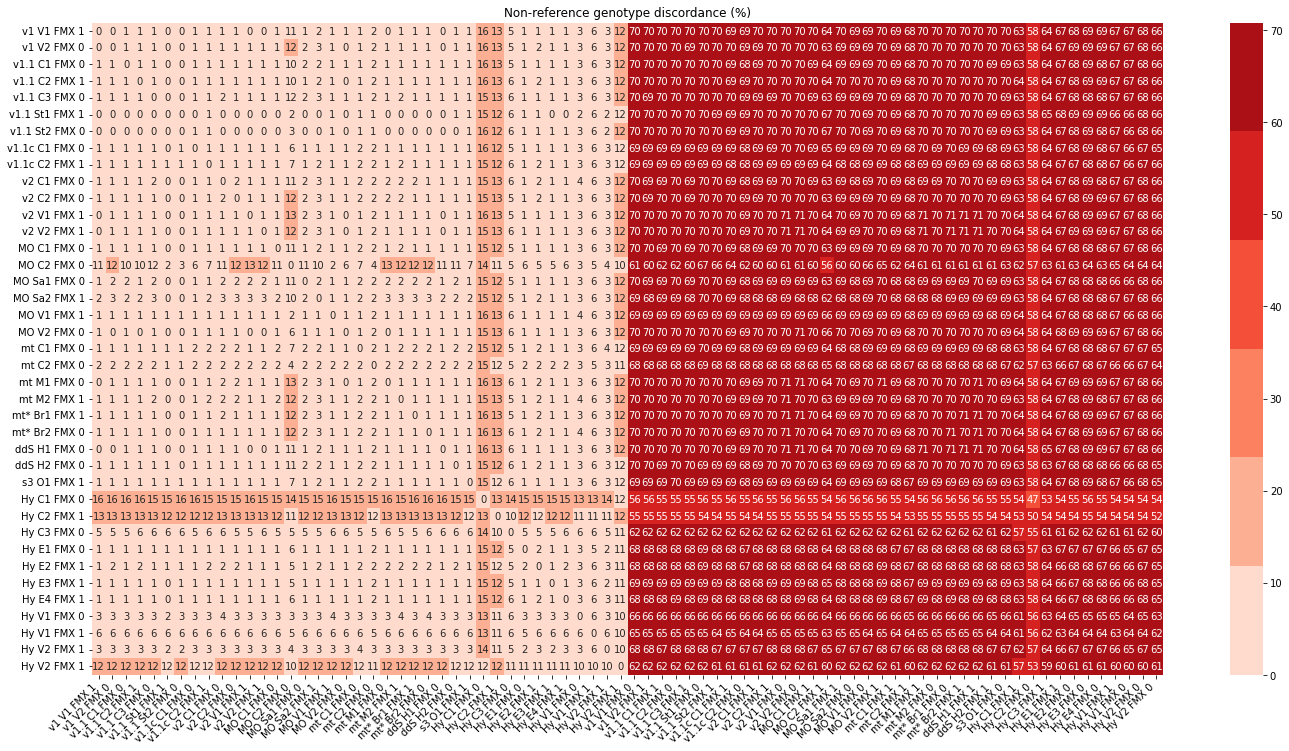

In [28]:
fig, ax = plt.subplots(figsize=(24, 12))
sns.heatmap(
    nrd.round(1),
    fmt=".0f",
    annot=True,
    linecolor="gray",
    yticklabels=True,
    xticklabels=True,
    vmin=0.0,
    vmax=nrd.max().max(),  # row_colors=colormap,
    cmap=sns.color_palette("Reds"),
    ax=ax,
)
# cmap='vlag',
# cbar_kws={'label': ''})
# figsize=(24,24) )
# g.cax.set_visible(True)
plt.xticks(rotation=45, ha="right")
plt.title("Non-reference genotype discordance (%)")
plt.savefig(
    "out_fmx/freemuxlet_nrd_fulldata.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
)
plt.savefig(
    "out_fmx/freemuxlet_nrd_fulldata.svg",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
)
plt.show()

Looking perfectly like we expected.

For the order:

In [ ]:
order = [nrd.index[x] for x in g.dendrogram_col.reordered_ind]
top_n = len(samples)
for line in ["'" + x[0:-7] + "', " for x in order][0:top_n]:
    print(line)

print('\n')

for line in ["c('" + x[0:-7] + "', " + x[-1] + ")," for x in order][0:top_n]:
    print(line)

Take the top n which belong to the pool to the following script.

# Run the R script to pair the genomes

In R image

In [ ]:
singularity run --cleanenv -H $PWD -B /lustre1,/staging,${VSC_SCRATCH}/tmp:/tmp /staging/leuven/stg_00002/lcb/cflerin/containers/cflerin-seurat-4.0.3-plus.sif

In [ ]:
f_fmx_dir = 'out_fmx/data/freemuxlet/'

samples = c(
    'CNA_hydrop_2.FIXEDCELLS', 
    'CNA_10xmultiome_2.FIXEDCELLS', 
    'CNA_mtscatac_2.FIXEDCELLS', 
    'VIB_hydrop_21.FIXEDCELLS', 
    'CNA_10xv11_5.FIXEDCELLS', 
    'EPF_hydrop_2.FIXEDCELLS', 
    'EPF_hydrop_3.FIXEDCELLS', 
    'EPF_hydrop_4.FIXEDCELLS', 
    'HAR_ddseq_2.FIXEDCELLS', 
    'CNA_10xv2_1.FIXEDCELLS', 
    'SAN_10xmultiome_1.FIXEDCELLS', 
    'SAN_10xmultiome_2.FIXEDCELLS', 
    'CNA_10xv11_2.FIXEDCELLS', 
    'HAR_ddseq_1.FIXEDCELLS', 
    'VIB_10xv1_1.FIXEDCELLS', 
    'MDC_mtscatac_1.FIXEDCELLS', 
    'BRO_mtscatac_1.FIXEDCELLS', 
    'BRO_mtscatac_2.FIXEDCELLS', 
    'VIB_10xv2_1.FIXEDCELLS', 
    'VIB_10xv2_2.FIXEDCELLS', 
    'CNA_10xv11_1.FIXEDCELLS', 
    'MDC_mtscatac_2.FIXEDCELLS', 
    'VIB_10xv1_2.FIXEDCELLS', 
    'CNA_10xv2_2.FIXEDCELLS', 
    'CNA_10xmultiome_1.FIXEDCELLS', 
    'CNA_10xv11_3.FIXEDCELLS', 
    'CNA_mtscatac_1.FIXEDCELLS', 
    'CNA_10xv11_4.FIXEDCELLS', 
    'OHS_s3atac_1.FIXEDCELLS', 
    'VIB_10xmultiome_2.FIXEDCELLS', 
    'STA_10xv11_1.FIXEDCELLS', 
    'STA_10xv11_2.FIXEDCELLS', 
    'VIB_10xmultiome_1.FIXEDCELLS', 
    'CNA_hydrop_1.FIXEDCELLS', 
    'CNA_hydrop_3.FIXEDCELLS', 
    'EPF_hydrop_1.FIXEDCELLS', 
    'VIB_hydrop_22.FIXEDCELLS', 
    'VIB_hydrop_11.FIXEDCELLS', 
    'VIB_hydrop_12.FIXEDCELLS'
    )

f_fmx = sapply(samples, function(s) paste0(f_fmx_dir,s,'_freemuxlet.clust1.samples.gz'))

fmx = lapply(f_fmx, read.delim, sep='\t', stringsAsFactors=FALSE)

# assign unique barcode:
for(i in 1:length(fmx)) {
    fmx[[i]]$ubarcode = paste(names(fmx)[i], "#", fmx[[i]]$BARCODE, sep="")
    fmx[[i]]$replicate = names(fmx)[i]
}


################################################################################
# freemuxlet sample pairing
################################################################################

# these groupings are made manually:
# based on the CLUST? in the heatmap

sampleA = list(
    c('CNA_hydrop_2.FIXEDCELLS', 0),
    c('CNA_10xmultiome_2.FIXEDCELLS', 1),
    c('CNA_mtscatac_2.FIXEDCELLS', 1),
    c('VIB_hydrop_21.FIXEDCELLS', 0),
    c('CNA_10xv11_5.FIXEDCELLS', 0),
    c('EPF_hydrop_2.FIXEDCELLS', 0),
    c('EPF_hydrop_3.FIXEDCELLS', 0),
    c('EPF_hydrop_4.FIXEDCELLS', 0),
    c('HAR_ddseq_2.FIXEDCELLS', 1),
    c('CNA_10xv2_1.FIXEDCELLS', 1),
    c('SAN_10xmultiome_1.FIXEDCELLS', 1),
    c('SAN_10xmultiome_2.FIXEDCELLS', 0),
    c('CNA_10xv11_2.FIXEDCELLS', 0),
    c('HAR_ddseq_1.FIXEDCELLS', 1),
    c('VIB_10xv1_1.FIXEDCELLS', 0),
    c('MDC_mtscatac_1.FIXEDCELLS', 1),
    c('BRO_mtscatac_1.FIXEDCELLS', 0),
    c('BRO_mtscatac_2.FIXEDCELLS', 1),
    c('VIB_10xv2_1.FIXEDCELLS', 0),
    c('VIB_10xv2_2.FIXEDCELLS', 0),
    c('CNA_10xv11_1.FIXEDCELLS', 1),
    c('MDC_mtscatac_2.FIXEDCELLS', 0),
    c('VIB_10xv1_2.FIXEDCELLS', 1),
    c('CNA_10xv2_2.FIXEDCELLS', 1),
    c('CNA_10xmultiome_1.FIXEDCELLS', 1),
    c('CNA_10xv11_3.FIXEDCELLS', 1),
    c('CNA_mtscatac_1.FIXEDCELLS', 1),
    c('CNA_10xv11_4.FIXEDCELLS', 1),
    c('OHS_s3atac_1.FIXEDCELLS', 0),
    c('VIB_10xmultiome_2.FIXEDCELLS', 1),
    c('STA_10xv11_1.FIXEDCELLS', 0),
    c('STA_10xv11_2.FIXEDCELLS', 1),
    c('VIB_10xmultiome_1.FIXEDCELLS', 0),
    c('CNA_hydrop_1.FIXEDCELLS', 1),
    c('CNA_hydrop_3.FIXEDCELLS', 1),
    c('EPF_hydrop_1.FIXEDCELLS', 1),
    c('VIB_hydrop_22.FIXEDCELLS', 0),
    c('VIB_hydrop_11.FIXEDCELLS', 1),
    c('VIB_hydrop_12.FIXEDCELLS', 0)
)

sampleB = lapply(sampleA, function(A) c(A[1], ifelse(A[2]==0,1,0)) )


fmxA = list()
for(i in 1:length(sampleA)) {
    rep = sampleA[[i]][1]
    clust = sampleA[[i]][2]
    tmp = fmx[[rep]]
    bestguess = paste(clust,',',clust,sep="")
    ix = which(tmp$BEST.GUESS==bestguess)
    tmp = tmp[ix,]
    tmp$replicate = rep
    tmp$sample = "sampleA"
    fmxA[[i]] = tmp
}
fmxB = list()
for(i in 1:length(sampleB)) {
    rep = sampleB[[i]][1]
    clust = sampleB[[i]][2]
    tmp = fmx[[rep]]
    bestguess = paste(clust,',',clust,sep="")
    ix = which(tmp$BEST.GUESS==bestguess)
    tmp = tmp[ix,]
    tmp$replicate = rep
    tmp$sample = "sampleB"
    fmxB[[i]] = tmp
}

fmxA = do.call("rbind",fmxA)
fmxB = do.call("rbind",fmxB)


# unified table:
fmx = do.call(rbind,fmx)

# check there are no unexpected intersections
intersect(fmxA$ubarcode,fmxB$ubarcode)

ixA = which(fmx$ubarcode %in% fmxA$ubarcode)
ixB = which(fmx$ubarcode %in% fmxB$ubarcode)
intersect(ixA,ixB)


fmx$sample = 'Undetermined'
fmx$sample[ixA] = "sampleA"
fmx$sample[ixB] = "sampleB"

write.table(fmx, file="out_fmx/genotype_concordance_unified.txt", sep='\t', quote=FALSE )

# Then, proceed again in python
 Yes, I know this is a horrible way of working.

In [30]:
f_gc = "out_fmx/genotype_concordance_unified.txt"

gc = pd.read_csv(f_gc, sep="\t")
gc

INT_ID               BARCODE  NUM.SNPS  \
CNA_hydrop_2.FIXEDCELLS.1           0  CGACATTACATAGGAGTCAA       182   
CNA_hydrop_2.FIXEDCELLS.2           1  GGCAACCTCTGAGCTAGTAA       209   
CNA_hydrop_2.FIXEDCELLS.3           2  CAACACCATTTCTCGCACGA       273   
CNA_hydrop_2.FIXEDCELLS.4           3  TGCATGAGGTTACGGACGGT       354   
CNA_hydrop_2.FIXEDCELLS.5           4  ACAGTGAAGATCCAGTGTTC       577   
...                               ...                   ...       ...   
VIB_hydrop_12.FIXEDCELLS.1417    1416  GTCGTTGAGAGTGACCAGTA       126   
VIB_hydrop_12.FIXEDCELLS.1418    1417  ACCGAAGGCTTTGCAGTTCT       103   
VIB_hydrop_12.FIXEDCELLS.1419    1418  TAGAGCCTGATTGTGTAGGA       115   
VIB_hydrop_12.FIXEDCELLS.1420    1419  CAATTGGAGACCACACGGAT       101   
VIB_hydrop_12.FIXEDCELLS.1421    1420  TCGTCACAAGATCCAGCGCA        96   

                               NUM.READS DROPLET.TYPE BEST.GUESS  BEST.LLK  \
CNA_hydrop_2.FIXEDCELLS.1            182          SNG        1,1   -324.11   
CNA_hydrop_2.FIXEDCELLS.2            209          SNG        0,0   -369.10   
CNA_hydrop_2.FIXEDCELLS.3            273          SNG        0,0   -492.20   
CNA_hydrop_2.FIXEDCELLS.4            354          SNG        1,1   -636.69   
CNA_hydrop_2.FIXEDCELLS.5            577          SNG        0,0  -1069.99   
...                                  ...          ...        ...       ...   
VIB_hydrop_12.FIXEDCELLS.1417        126          SNG        1,1   -221.86   
VIB_hydrop_12.FIXEDCELLS.1418        103          SNG        1,1   -185.75   
VIB_hydrop_12.FIXEDCELLS.1419        115          SNG        1,1   -207.21   
VIB_hydrop_12.FIXEDCELLS.1420        101          SNG        1,1   -177.98   
VIB_hydrop_12.FIXEDCELLS.1421         96          SNG        0,0   -165.04   

                              NEXT.GUESS  NEXT.LLK  DIFF.LLK.BEST.NEXT  ...  \
CNA_hydrop_2.FIXEDCELLS.1            1,0   -343.05               18.94  ...   
CNA_hydrop_2.FIXEDCELLS.2            1,0   -390.29               21.19  ...   
CNA_hydrop_2.FIXEDCELLS.3            1,0   -520.48               28.28  ...   
CNA_hydrop_2.FIXEDCELLS.4            1,0   -669.83               33.14  ...   
CNA_hydrop_2.FIXEDCELLS.5            1,0  -1093.26               23.27  ...   
...                                  ...       ...                 ...  ...   
VIB_hydrop_12.FIXEDCELLS.1417        1,0   -240.94               19.08  ...   
VIB_hydrop_12.FIXEDCELLS.1418        1,0   -198.81               13.06  ...   
VIB_hydrop_12.FIXEDCELLS.1419        1,0   -219.27               12.06  ...   
VIB_hydrop_12.FIXEDCELLS.1420        1,0   -188.29               10.31  ...   
VIB_hydrop_12.FIXEDCELLS.1421        1,0   -177.31               12.28  ...   

                               SNG.BEST.LLK  SNG.NEXT.GUESS  SNG.NEXT.LLK  \
CNA_hydrop_2.FIXEDCELLS.1           -324.11               0       -373.28   
CNA_hydrop_2.FIXEDCELLS.2           -369.10               1       -426.11   
CNA_hydrop_2.FIXEDCELLS.3           -492.20               1       -576.63   
CNA_hydrop_2.FIXEDCELLS.4           -636.69               0       -734.25   
CNA_hydrop_2.FIXEDCELLS.5          -1069.99               1      -1173.29   
...                                     ...             ...           ...   
VIB_hydrop_12.FIXEDCELLS.1417       -221.86               0       -283.50   
VIB_hydrop_12.FIXEDCELLS.1418       -185.75               0       -226.20   
VIB_hydrop_12.FIXEDCELLS.1419       -207.21               0       -244.26   
VIB_hydrop_12.FIXEDCELLS.1420       -177.98               0       -214.34   
VIB_hydrop_12.FIXEDCELLS.1421       -165.04               1       -201.88   

                               SNG.ONLY.POSTERIOR  DBL.BEST.GUESS  \
CNA_hydrop_2.FIXEDCELLS.1                     1.0             1,0   
CNA_hydrop_2.FIXEDCELLS.2                     1.0             1,0   
CNA_hydrop_2.FIXEDCELLS.3                     1.0             1,0   
CNA_hydrop_2.FIXEDCELLS.4                     1.0             1,0  

### Freemuxlet plots

Loading data from unified fmeemuxlet annotations (inferred samples are linked)

In [31]:
#

tp = gc[["replicate", "sample"]].copy()
tp["droplet_type"] = tp["sample"].copy()
tp.loc[tp["droplet_type"] == "Undetermined", "droplet_type"] = "Doublet"
tp = tp.groupby(["replicate", "droplet_type"]).size().rename("count").reset_index()

tp.columns = ["sampleId", "droplet_type", "count"]
tp.sort_values("sampleId", inplace=True)

In [32]:
tp["sampleId"] = [
    x.replace("CNA_10xv11_4", "CNA_10xv11c_1")
    .replace("CNA_10xv11_5", "CNA_10xv11c_2")
    .replace("BRO_mtscatac", "BRO_mtscatacfacs")
    for x in tp["sampleId"]
]

In [33]:
# get all unique freemuxlet calls:
# bgu = tp['droplet_type'].unique()
# bgu.sort()
bgu = ["sampleA", "Doublet", "sampleB"]

In [34]:
bgu = tp["droplet_type"].unique()
bgu

array(['Doublet', 'sampleA', 'sampleB'], dtype=object)

In [35]:
tp.index = tp["sampleId"]

In [36]:
tp[["VIB_hy" in x for x in tp.index]]

sampleId droplet_type  count
sampleId                                                              
VIB_hydrop_11.FIXEDCELLS  VIB_hydrop_11.FIXEDCELLS      Doublet      2
VIB_hydrop_11.FIXEDCELLS  VIB_hydrop_11.FIXEDCELLS      sampleA    599
VIB_hydrop_11.FIXEDCELLS  VIB_hydrop_11.FIXEDCELLS      sampleB    502
VIB_hydrop_12.FIXEDCELLS  VIB_hydrop_12.FIXEDCELLS      sampleA    779
VIB_hydrop_12.FIXEDCELLS  VIB_hydrop_12.FIXEDCELLS      Doublet      4
VIB_hydrop_12.FIXEDCELLS  VIB_hydrop_12.FIXEDCELLS      sampleB    638
VIB_hydrop_21.FIXEDCELLS  VIB_hydrop_21.FIXEDCELLS      sampleA   1149
VIB_hydrop_21.FIXEDCELLS  VIB_hydrop_21.FIXEDCELLS      Doublet     31
VIB_hydrop_21.FIXEDCELLS  VIB_hydrop_21.FIXEDCELLS      sampleB    893
VIB_hydrop_22.FIXEDCELLS  VIB_hydrop_22.FIXEDCELLS      sampleA    531
VIB_hydrop_22.FIXEDCELLS  VIB_hydrop_22.FIXEDCELLS      Doublet      1
VIB_hydrop_22.FIXEDCELLS  VIB_hydrop_22.FIXEDCELLS      sampleB    437

In [37]:
df_hy = pd.DataFrame(
    columns=["sampleId", "droplet_type", "count"],
    index=[
        "VIB_hydrop_1.FIXEDCELLS",
        "VIB_hydrop_1.FIXEDCELLS",
        "VIB_hydrop_1.FIXEDCELLS",
        "VIB_hydrop_2.FIXEDCELLS",
        "VIB_hydrop_2.FIXEDCELLS",
        "VIB_hydrop_2.FIXEDCELLS",
    ],
)

df_hy["sampleId"] = df_hy.index
df_hy["droplet_type"] = [
    "Doublet",
    "sampleA",
    "sampleB",
    "Doublet",
    "sampleA",
    "sampleB",
]
df_hy["count"] = [6, 1378, 1140, 32, 1680, 1330]
df_hy

sampleId droplet_type  count
VIB_hydrop_1.FIXEDCELLS  VIB_hydrop_1.FIXEDCELLS      Doublet      6
VIB_hydrop_1.FIXEDCELLS  VIB_hydrop_1.FIXEDCELLS      sampleA   1378
VIB_hydrop_1.FIXEDCELLS  VIB_hydrop_1.FIXEDCELLS      sampleB   1140
VIB_hydrop_2.FIXEDCELLS  VIB_hydrop_2.FIXEDCELLS      Doublet     32
VIB_hydrop_2.FIXEDCELLS  VIB_hydrop_2.FIXEDCELLS      sampleA   1680
VIB_hydrop_2.FIXEDCELLS  VIB_hydrop_2.FIXEDCELLS      sampleB   1330

In [ ]:
tp = tp.drop(
    [
        "VIB_hydrop_11.FIXEDCELLS",
        "VIB_hydrop_11.FIXEDCELLS",
        "VIB_hydrop_11.FIXEDCELLS",
        "VIB_hydrop_12.FIXEDCELLS",
        "VIB_hydrop_12.FIXEDCELLS",
        "VIB_hydrop_12.FIXEDCELLS",
        "VIB_hydrop_21.FIXEDCELLS",
        "VIB_hydrop_21.FIXEDCELLS",
        "VIB_hydrop_21.FIXEDCELLS",
        "VIB_hydrop_22.FIXEDCELLS",
        "VIB_hydrop_22.FIXEDCELLS",
        "VIB_hydrop_22.FIXEDCELLS",
        "VIB_hydrop_1.FIXEDCELLS",
        "VIB_hydrop_1.FIXEDCELLS",
        "VIB_hydrop_1.FIXEDCELLS",
        "VIB_hydrop_2.FIXEDCELLS",
        "VIB_hydrop_2.FIXEDCELLS",
        "VIB_hydrop_2.FIXEDCELLS",
    ],
    axis=0,
)

In [43]:
tp

sampleId droplet_type  \
sampleId                                                                    
BRO_mtscatacfacs_1.FIXEDCELLS  BRO_mtscatacfacs_1.FIXEDCELLS      Doublet   
BRO_mtscatacfacs_1.FIXEDCELLS  BRO_mtscatacfacs_1.FIXEDCELLS      sampleA   
BRO_mtscatacfacs_1.FIXEDCELLS  BRO_mtscatacfacs_1.FIXEDCELLS      sampleB   
BRO_mtscatacfacs_2.FIXEDCELLS  BRO_mtscatacfacs_2.FIXEDCELLS      Doublet   
BRO_mtscatacfacs_2.FIXEDCELLS  BRO_mtscatacfacs_2.FIXEDCELLS      sampleA   
...                                                      ...          ...   
VIB_hydrop_21.FIXEDCELLS            VIB_hydrop_21.FIXEDCELLS      Doublet   
VIB_hydrop_21.FIXEDCELLS            VIB_hydrop_21.FIXEDCELLS      sampleB   
VIB_hydrop_22.FIXEDCELLS            VIB_hydrop_22.FIXEDCELLS      sampleA   
VIB_hydrop_22.FIXEDCELLS            VIB_hydrop_22.FIXEDCELLS      Doublet   
VIB_hydrop_22.FIXEDCELLS            VIB_hydrop_22.FIXEDCELLS      sampleB   

                               count  
sampleId                              
BRO_mtscatacfacs_1.FIXEDCELLS     28  
BRO_mtscatacfacs_1.FIXEDCELLS   1738  
BRO_mtscatacfacs_1.FIXEDCELLS   1810  
BRO_mtscatacfacs_2.FIXEDCELLS     24  
BRO_mtscatacfacs_2.FIXEDCELLS   1603  
...                              ...  
VIB_hydrop_21.FIXEDCELLS          31  
VIB_hydrop_21.FIXEDCELLS         893  
VIB_hydrop_22.FIXEDCELLS         531  
VIB_hydrop_22.FIXEDCELLS           1  
VIB_hydrop_22.FIXEDCELLS         437  

[108 rows x 3 columns]

In [44]:
tp = pd.concat([tp, df_hy])

In [45]:
tp

sampleId droplet_type  \
BRO_mtscatacfacs_1.FIXEDCELLS  BRO_mtscatacfacs_1.FIXEDCELLS      Doublet   
BRO_mtscatacfacs_1.FIXEDCELLS  BRO_mtscatacfacs_1.FIXEDCELLS      sampleA   
BRO_mtscatacfacs_1.FIXEDCELLS  BRO_mtscatacfacs_1.FIXEDCELLS      sampleB   
BRO_mtscatacfacs_2.FIXEDCELLS  BRO_mtscatacfacs_2.FIXEDCELLS      Doublet   
BRO_mtscatacfacs_2.FIXEDCELLS  BRO_mtscatacfacs_2.FIXEDCELLS      sampleA   
...                                                      ...          ...   
VIB_hydrop_1.FIXEDCELLS              VIB_hydrop_1.FIXEDCELLS      sampleA   
VIB_hydrop_1.FIXEDCELLS              VIB_hydrop_1.FIXEDCELLS      sampleB   
VIB_hydrop_2.FIXEDCELLS              VIB_hydrop_2.FIXEDCELLS      Doublet   
VIB_hydrop_2.FIXEDCELLS              VIB_hydrop_2.FIXEDCELLS      sampleA   
VIB_hydrop_2.FIXEDCELLS              VIB_hydrop_2.FIXEDCELLS      sampleB   

                               count  
BRO_mtscatacfacs_1.FIXEDCELLS     28  
BRO_mtscatacfacs_1.FIXEDCELLS   1738  
BRO_mtscatacfacs_1.FIXEDCELLS   1810  
BRO_mtscatacfacs_2.FIXEDCELLS     24  
BRO_mtscatacfacs_2.FIXEDCELLS   1603  
...                              ...  
VIB_hydrop_1.FIXEDCELLS         1378  
VIB_hydrop_1.FIXEDCELLS         1140  
VIB_hydrop_2.FIXEDCELLS           32  
VIB_hydrop_2.FIXEDCELLS         1680  
VIB_hydrop_2.FIXEDCELLS         1330  

[114 rows x 3 columns]

In [46]:
sample_order = [
    "VIB_10xv1_1.FIXEDCELLS",
    "VIB_10xv1_2.FIXEDCELLS",
    "CNA_10xv11_1.FIXEDCELLS",
    "CNA_10xv11_2.FIXEDCELLS",
    "CNA_10xv11_3.FIXEDCELLS",
    "STA_10xv11_1.FIXEDCELLS",
    "STA_10xv11_2.FIXEDCELLS",
    "CNA_10xv11c_1.FIXEDCELLS",
    "CNA_10xv11c_2.FIXEDCELLS",
    "CNA_10xv2_1.FIXEDCELLS",
    "CNA_10xv2_2.FIXEDCELLS",
    "VIB_10xv2_1.FIXEDCELLS",
    "VIB_10xv2_2.FIXEDCELLS",
    "CNA_10xmultiome_1.FIXEDCELLS",
    "CNA_10xmultiome_2.FIXEDCELLS",
    "SAN_10xmultiome_1.FIXEDCELLS",
    "SAN_10xmultiome_2.FIXEDCELLS",
    "VIB_10xmultiome_1.FIXEDCELLS",
    "VIB_10xmultiome_2.FIXEDCELLS",
    "CNA_mtscatac_1.FIXEDCELLS",
    "CNA_mtscatac_2.FIXEDCELLS",
    "MDC_mtscatac_1.FIXEDCELLS",
    "MDC_mtscatac_2.FIXEDCELLS",
    "BRO_mtscatacfacs_1.FIXEDCELLS",
    "BRO_mtscatacfacs_2.FIXEDCELLS",
    "HAR_ddseq_1.FIXEDCELLS",
    "HAR_ddseq_2.FIXEDCELLS",
    "OHS_s3atac_1.FIXEDCELLS",
    "CNA_hydrop_1.FIXEDCELLS",
    "CNA_hydrop_2.FIXEDCELLS",
    "CNA_hydrop_3.FIXEDCELLS",
    "EPF_hydrop_1.FIXEDCELLS",
    "EPF_hydrop_2.FIXEDCELLS",
    "EPF_hydrop_3.FIXEDCELLS",
    "EPF_hydrop_4.FIXEDCELLS",
    "VIB_hydrop_1.FIXEDCELLS",
    "VIB_hydrop_2.FIXEDCELLS",
]

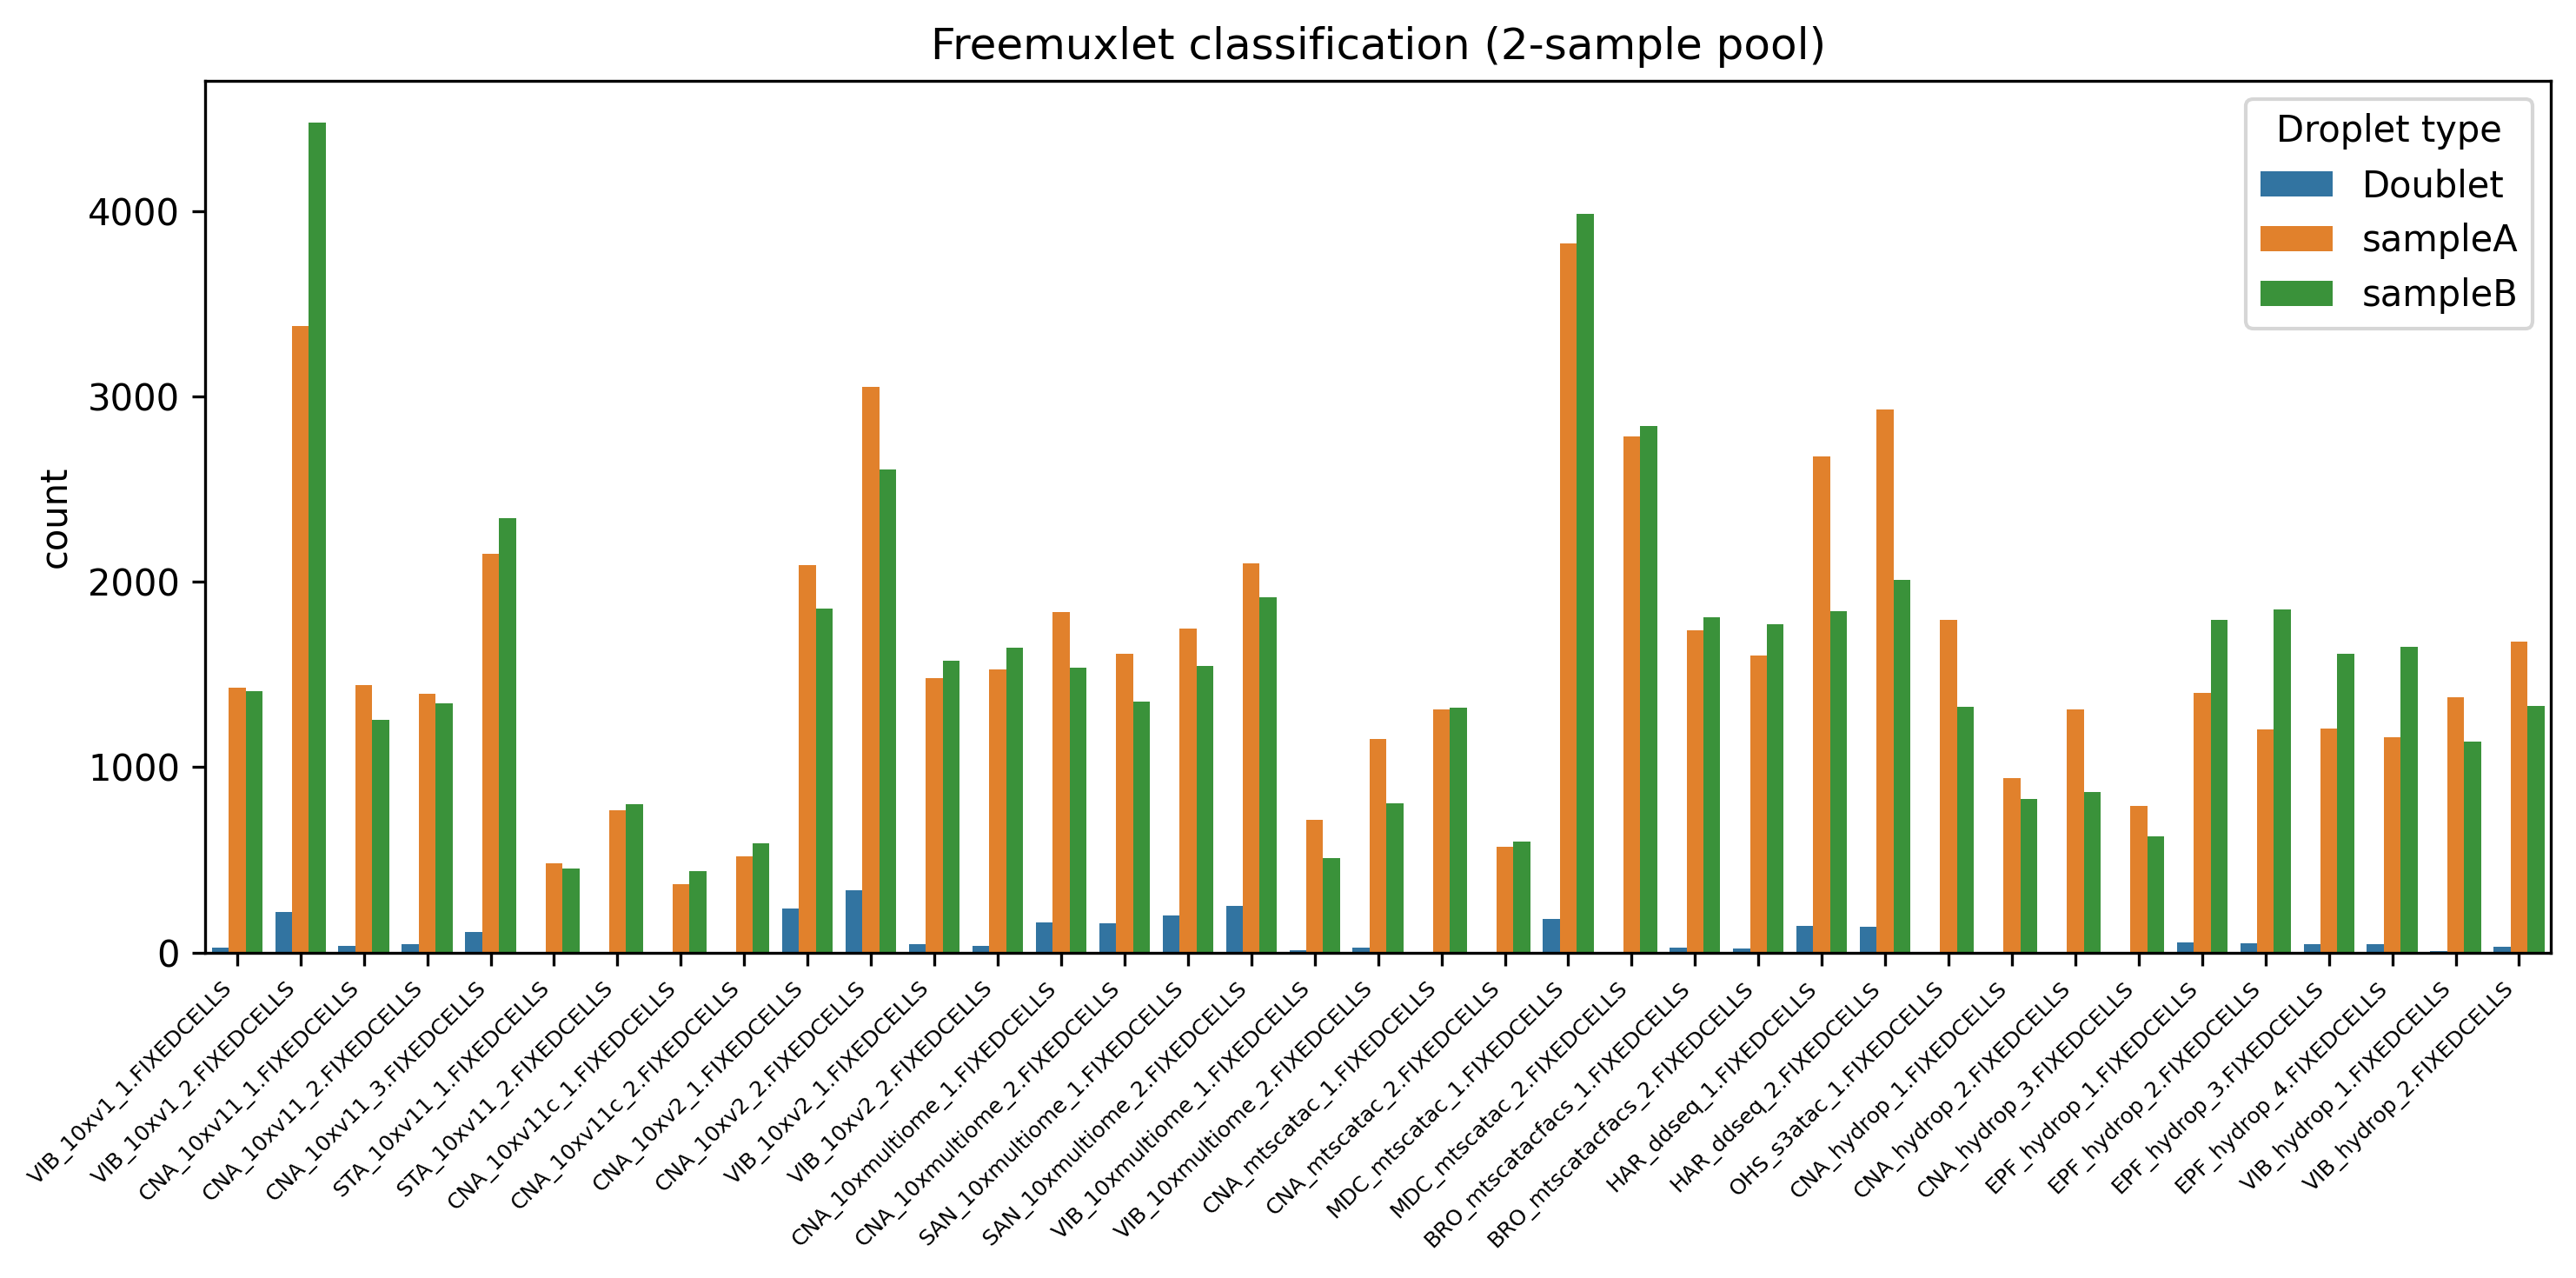

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)

g = sns.barplot(
    x="sampleId", y="count", hue="droplet_type", data=tp, ax=ax, order=sample_order
)
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right", fontsize=6)

ax.set_title("Freemuxlet classification (2-sample pool)")
ax.legend(title="Droplet type")
ax.set_xlabel("")

plt.tight_layout()
plt.show()

In [48]:
tp["sampleId"] = [sample_id_ultrashort_alias_dict[x] for x in tp["sampleId"]]

In [49]:
donor_dict = {"Doublet": "Doublet", "sampleA": "Male donor", "sampleB": "Female donor"}

In [50]:
tp["droplet_type"] = [donor_dict[x] for x in tp["droplet_type"]]

In [51]:
tp = tp.loc[sample_order]

In [52]:
tp_pivot = tp.pivot(index="sampleId", columns="droplet_type", values="count")

In [53]:
tp_pivot_normalized = tp_pivot.div(tp_pivot.sum(axis=1), axis=0)

In [54]:
sample_order_alias = [sample_id_ultrashort_alias_dict[x] for x in sample_order]

In [55]:
tp_pivot_normalized = tp_pivot_normalized.loc[sample_order_alias]

In [56]:
tp_pivot_normalized

droplet_type   Doublet  Female donor  Male donor
sampleId                                        
v1 V1         0.009069      0.492501    0.498430
v1 V2         0.027218      0.554250    0.418533
v1.1 C1       0.013899      0.458669    0.527432
v1.1 C2       0.015434      0.483130    0.501436
v1.1 C3       0.023892      0.508688    0.467420
v1.1 St1           NaN      0.486631    0.513369
v1.1 St2           NaN      0.510178    0.489822
v1.1c C1           NaN      0.543532    0.456468
v1.1c C2      0.002698      0.529676    0.467626
v2 C1         0.056459      0.443780    0.499761
v2 C2         0.056380      0.434696    0.508924
v2 V1         0.015132      0.507405    0.477463
v2 V2         0.011526      0.512461    0.476012
MO C1         0.046084      0.434549    0.519367
MO C2         0.049952      0.433237    0.516811
MO Sa1        0.056971      0.442886    0.500143
MO Sa2        0.059251      0.449415    0.491335
MO V1         0.008892      0.413096    0.578011
MO V2         0.013616      0.405446    0.580938
mt C1              NaN      0.502278    0.497722
mt C2              NaN      0.511111    0.488889
mt M1         0.022400      0.498686    0.478914
mt M2         0.000533      0.504708    0.494759
mt* Br1       0.007830      0.506152    0.486018
mt* Br2       0.007061      0.521330    0.471609
ddS H1        0.031103      0.394895    0.574003
ddS H2        0.027165      0.395866    0.576969
s3 O1              NaN      0.424543    0.575457
Hy C1              NaN      0.467532    0.532468
Hy C2              NaN      0.398072    0.601928
Hy C3              NaN      0.443583    0.556417
Hy E1         0.016605      0.551968    0.431427
Hy E2         0.015781      0.596457    0.387762
Hy E3         0.016061      0.562500    0.421439
Hy E4         0.015401      0.577529    0.407070
Hy V1         0.002377      0.451664    0.545959
Hy V2         0.010519      0.437212    0.552268

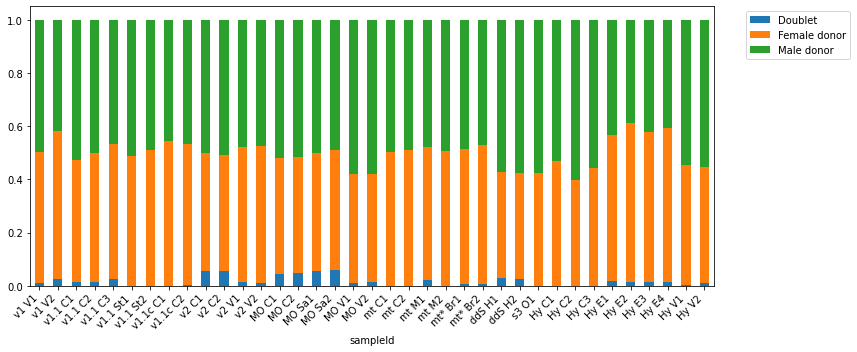

In [57]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(12)

tp_pivot_normalized.plot(kind="bar", stacked=True, ax=axes)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.savefig("plots_pub/freemuxlet_normalized.png", dpi=300, facecolor="white")

In [58]:
tp_pivot = tp_pivot.loc[sample_order_alias]

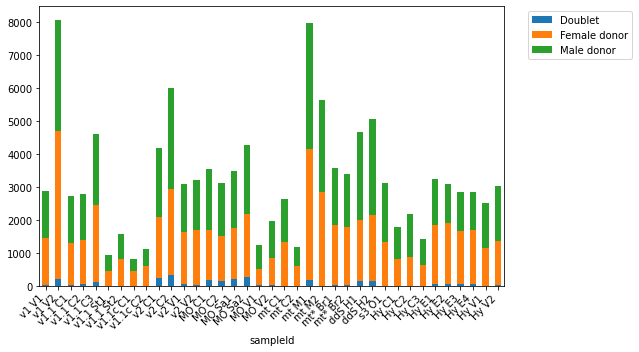

In [59]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(9)

tp_pivot.plot(kind="bar", stacked=True, ax=axes)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.savefig("plots_pub/freemuxlet.png", dpi=300, facecolor="white")
plt.savefig("plots_pub/freemuxlet.svg", dpi=300, facecolor="white")

In [60]:
bgu

array(['Doublet', 'sampleA', 'sampleB'], dtype=object)

In [61]:
csum = pd.DataFrame([], index=tp["sampleId"].unique())
# csum['lower']=0
for y in ["Doublet", "Male donor", "Female donor"]:
    # print(tp[ tp['droplet_type']==y ])
    tmp = tp[tp["droplet_type"] == y].set_index("sampleId")
    # csum[y] = pd.merge(csum, tmp['count'], left_index=True, right_index=True, how='left').sum(axis=1)
    csum[y] = tmp["count"]

csum.fillna(0, inplace=True)
csum

Doublet  Male donor  Female donor
v1 V1        26.0        1429          1412
v1 V2       220.0        3383          4480
v1.1 C1      38.0        1442          1254
v1.1 C2      43.0        1397          1346
v1.1 C3     110.0        2152          2342
v1.1 St1      0.0         480           455
v1.1 St2      0.0         770           802
v1.1c C1      0.0         367           437
v1.1c C2      3.0         520           589
v2 C1       236.0        2089          1855
v2 C2       338.0        3051          2606
v2 V1        47.0        1483          1576
v2 V2        37.0        1528          1645
MO C1       163.0        1837          1537
MO C2       156.0        1614          1353
MO Sa1      199.0        1747          1547
MO Sa2      253.0        2098          1919
MO V1        11.0         715           511
MO V2        27.0        1152           804
mt C1         0.0        1311          1323
mt C2         0.0         572           598
mt M1       179.0        3827          3985
mt M2         3.0        2785          2841
mt* Br1      28.0        1738          1810
mt* Br2      24.0        1603          1772
ddS H1      145.0        2676          1841
ddS H2      138.0        2931          2011
s3 O1         0.0        1796          1325
Hy C1         0.0         943           828
Hy C2         0.0        1311           867
Hy C3         0.0         789           629
Hy E1        54.0        1403          1795
Hy E2        49.0        1204          1852
Hy E3        46.0        1207          1611
Hy E4        44.0        1163          1650
Hy V1         6.0        1378          1140
Hy V2        32.0        1680          1330

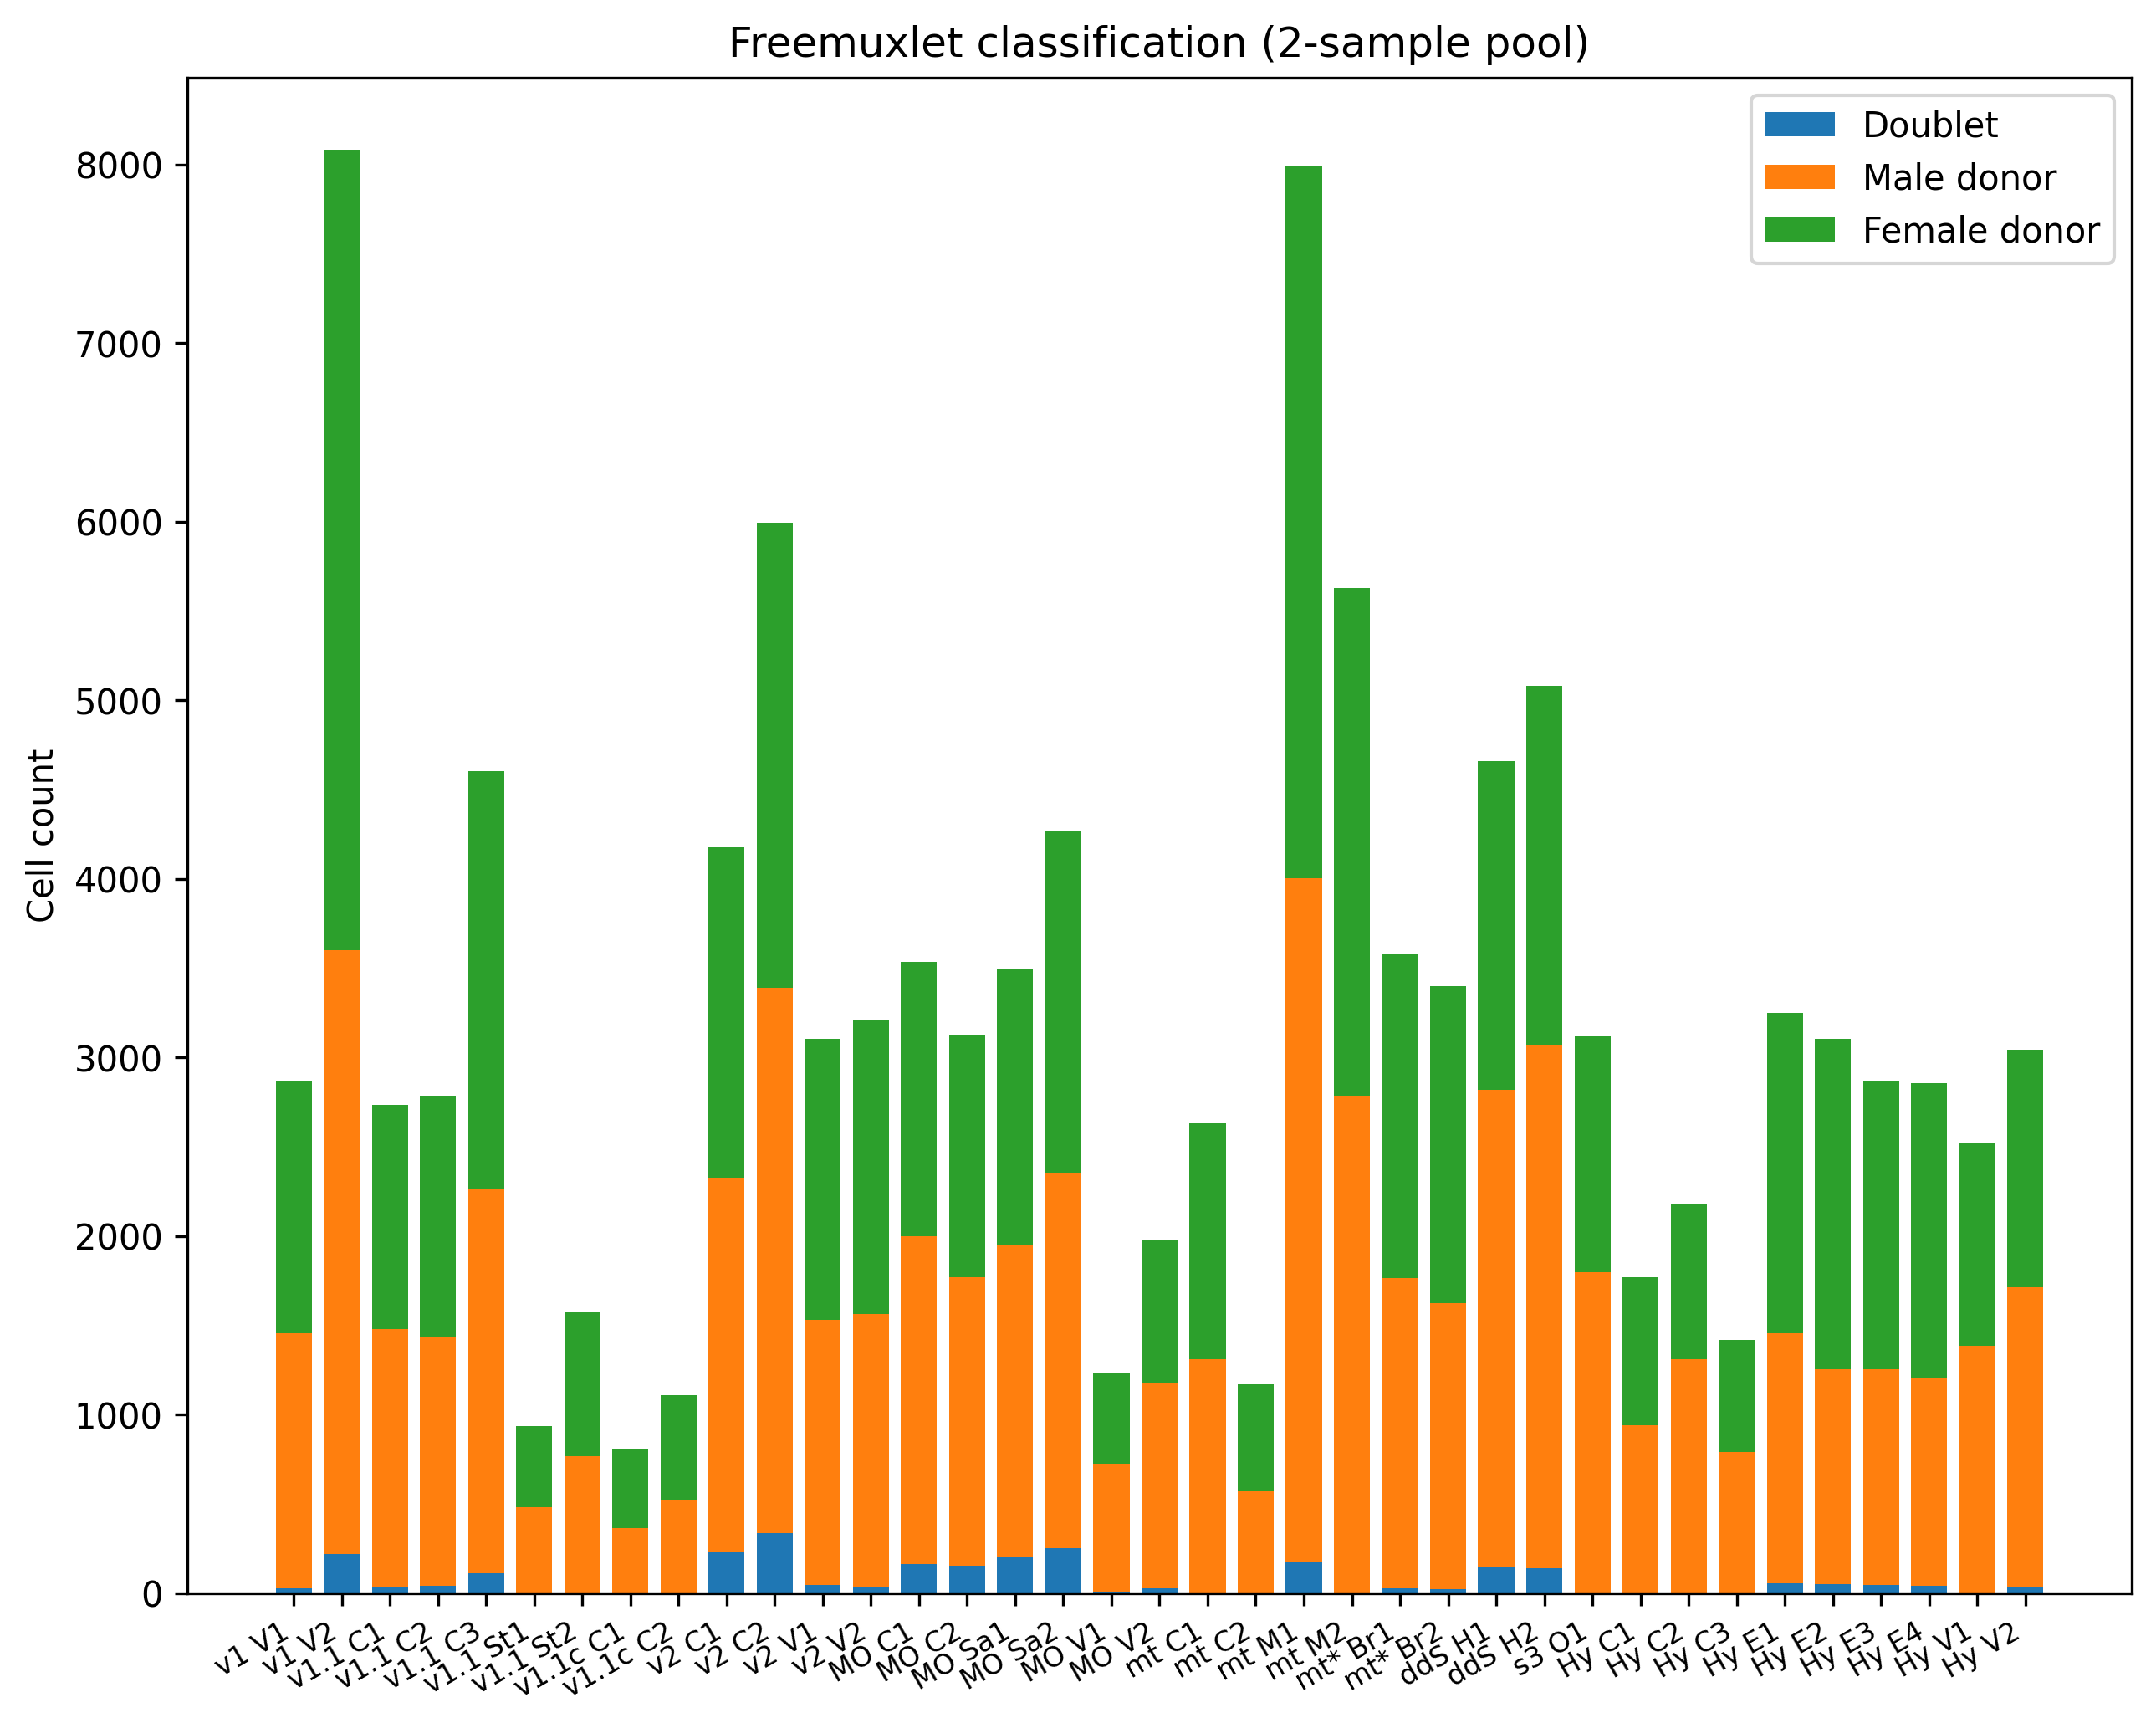

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)

width = 0.75

lower = pd.DataFrame([], index=tp["sampleId"].unique())
lower["lower"] = 0
for y in ["Doublet", "Male donor", "Female donor"]:
    ax.bar(
        x=csum.index, height=csum[y], width=width, bottom=lower["lower"], label=y
    )  # , color='#377CB6')
    lower["lower"] = csum.iloc[:, : (csum.columns.get_loc(y) + 1)].sum(axis=1)

ax.set_ylabel("Cell count")
ax.set_xlabel("")
plt.xticks(rotation=30, ha="right", fontsize=8)

ax.set_title("Freemuxlet classification (2-sample pool)")
ax.legend()  # title='Freemuxlet')
plt.savefig("plots_qc/freemuxlet_counts.png", facecolor="white")
plt.show()